<a href="https://colab.research.google.com/github/eisbetterthanpi/latent-flow-model/blob/main/flow_matching_me.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title SpatialTransformer down
# https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/attention.py
import torch
from torch import nn
import torch.nn.functional as F


class GEGLU(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.proj = nn.Linear(dim_in, dim_out * 2)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim=-1)
        return x * F.gelu(gate)


from einops import rearrange, repeat
class CrossAttention(nn.Module):
    def __init__(self, query_dim, cond_dim=None, n_heads=8, d_head=64, drop=0.):
        super().__init__()
        d_model = d_head * n_heads
        self.n_heads, self.d_head, self.d_model = n_heads, d_head, d_model
        if cond_dim == None: cond_dim = query_dim
        self.scale = d_head ** -0.5
        self.n_heads = n_heads
        self.q = nn.Linear(query_dim, d_model, bias=False)
        self.k = nn.Linear(cond_dim, d_model, bias=False)
        self.v = nn.Linear(cond_dim, d_model, bias=False)
        self.lin = nn.Sequential(nn.Linear(d_model, query_dim), nn.Dropout(drop),)

    def forward(self, x, cond=None, mask=None): # [batch, h*w, n_heads*d_head]
        # print("crossattn fwd x", x.shape)
        h = self.n_heads
        if cond==None: cond=x
        Q, K, V = self.q(x), self.k(cond), self.v(cond)
        Q, K, V = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (Q, K, V)) # [batch*n_heads, h*w, d_head]
        sim = Q @ K.transpose(1, 2) * self.scale
        if mask!=None: sim.masked_fill_(~mask.flatten(1).repeat(h,1).unsqueeze(1), -torch.finfo(sim.dtype).max) # -1e10, 3.4028234663852886e+38
        attn = sim.softmax(dim=-1)
        out = attn @ V # [batch*n_heads, h*w, d_head]
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.lin(out) # [batch, h*w, n_heads*d_head]

    def forward(self, x, cond=None, mask=None): # [batch, h*w, n_heads*d_head]
        h = self.n_heads
        batch_size = x.shape[0]
        if cond==None: cond=x
        Q = self.q(x).reshape(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2) # [batch, n_heads, h*w, d_head]
        K = self.k(cond).reshape(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        V = self.v(cond).reshape(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        sim = Q @ K.transpose(2, 3) * self.scale
        # if mask!=None: sim.masked_fill_(~mask.unsqueeze(1).repeat(1,self.n_heads), -torch.finfo(sim.dtype).max) # -1e10, 3.4028234663852886e+38 [batch, h,w]?-> [batch,n_heads, h*w]?
        attn = sim.softmax(dim=-1)
        out = attn @ V # [batch*n_heads, h*w, d_head]
        out = out.transpose(1, 2).reshape(batch_size, -1, self.d_model)
        return self.lin(out) # [batch, h*w, n_heads*d_head]


class BasicTransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_head, drop=0., cond_dim=None):
        super().__init__()
        self.attn1 = CrossAttention(query_dim=d_model, n_heads=n_heads, d_head=d_head, drop=drop)  # is a self-attention
        self.attn2 = CrossAttention(query_dim=d_model, cond_dim=cond_dim, n_heads=n_heads, d_head=d_head, drop=drop)  # is self-attn if cond is none
        self.norm1, self.norm2, self.norm3 = nn.RMSNorm(d_model), nn.RMSNorm(d_model), nn.RMSNorm(d_model) # RMSNorm LayerNorm
        inner_dim = d_model * 4
        self.ff = nn.Sequential(
            nn.Linear(d_model, inner_dim), nn.GELU(), # nn.GELU() GEGLU(d_model, inner_dim)
            nn.Dropout(drop), nn.Linear(inner_dim, d_model),)

    def forward(self, x, cond=None):
        x = self.attn1(self.norm1(x)) + x
        x = self.attn2(self.norm2(x), cond=cond) + x
        x = self.ff(self.norm3(x)) + x
        return x


class SpatialTransformer(nn.Module):
    """Transformer block for image-like data.
    First, project the input (aka embedding) and reshape to b, t, d.
    Then apply standard transformer action.
    Finally, reshape to image"""
    def __init__(self, in_ch, n_heads, d_head, depth=1, drop=0., cond_dim=None):
        super().__init__()
        self.cond=True
        self.in_ch = in_ch
        d_model = n_heads * d_head
        self.norm = nn.GroupNorm(num_groups=min(32,in_ch), num_channels=in_ch)
        self.proj_in = nn.Conv2d(in_ch, d_model, kernel_size=1, stride=1, padding=0)
        self.transformer_blocks = nn.ModuleList([BasicTransformerBlock(d_model, n_heads, d_head, drop=drop, cond_dim=cond_dim) for d in range(depth)])
        self.proj_out = zero_module(nn.Conv2d(d_model, in_ch, kernel_size=1, stride=1, padding=0))
        # self.proj_out = nn.Conv2d(d_model, in_ch, kernel_size=1, stride=1, padding=0)
        # nn.init.zeros_(self.proj_out.weight)

    def forward(self, x, cond=None): # note: if no cond is given, cross-attention defaults to self-attention
        b, c, h, w = x.shape
        if cond!=None: cond = cond.unsqueeze(1).repeat(1,self.in_ch,1)
        x_in = x
        x = self.proj_in(self.norm(x))
        # x = rearrange(x, 'b c h w -> b (h w) c')
        x = x.flatten(2).transpose(1, 2)
        for block in self.transformer_blocks:
            x = block(x, cond=cond)
        # x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = x.transpose(1, 2).reshape(b, c, h, w)
        x = self.proj_out(x)
        return x + x_in

batch=4
in_ch=32 # assert in_ch % 32 == 0 for groupnorm32
cond_dim=16
h=w=16
n_heads, d_head = 2, 8
# sptf = SpatialTransformer(in_ch=32, n_heads=8, d_head=4, depth=1, drop=0., cond_dim=16)
sptf = SpatialTransformer(in_ch, n_heads, d_head, depth=1, cond_dim=cond_dim)
x = torch.rand(batch,in_ch,h,w)
# cond = torch.rand(4,64,16)
cond = torch.rand(4,16)
# cond = torch.rand(batch,cond_dim).unsqueeze(1).repeat(1,in_ch,1)
out = sptf(x, cond)
print(out.shape) # batch,in_ch,h,w

torch.Size([4, 32, 16, 16])


In [ ]:
# @title stable diffusion util
# https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/diffusionmodules/util.py
# adopted from
# https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/gaussian_diffusion.py
# https://github.com/lucidrains/denoising-diffusion-pytorch/blob/7706bdfc6f527f58d33f84b7b522e61e6e3164b3/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py
# https://github.com/openai/guided-diffusion/blob/0ba878e517b276c45d1195eb29f6f5f72659a05b/guided_diffusion/nn.py

import os
import math
import torch
import torch.nn as nn
import numpy as np
from einops import repeat


def timestep_embedding(timesteps, dim, max_period=10000, repeat_only=False):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element. These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    if not repeat_only:
        half = dim // 2
        # freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(device=device)
        freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half) / half)#.to(device)
        # args = timesteps[:, None].float() * freqs[None]
        args = timesteps[:, None] * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2: embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    else: embedding = repeat(timesteps, 'b -> b d', d=dim)
    return embedding

# # timesteps = torch.arange(0, 10)
# timesteps = torch.linspace(0, 1, 10)
# print(timesteps)
# model_channels=8
# t_emb = timestep_embedding(timesteps, model_channels, repeat_only=False)
# print(t_emb)


def zero_module(module):
    """Zero out the parameters of a module and return it."""
    for p in module.parameters():
        p.detach().zero_()
    return module

def conv_nd(dims, *args, **kwargs):
    """Create a 1D, 2D, or 3D convolution module."""
    if dims == 1: return nn.Conv1d(*args, **kwargs)
    elif dims == 2: return nn.Conv2d(*args, **kwargs)
    elif dims == 3: return nn.Conv3d(*args, **kwargs)


def avg_pool_nd(dims, *args, **kwargs):
    """Create a 1D, 2D, or 3D average pooling module."""
    if dims == 1: return nn.AvgPool1d(*args, **kwargs)
    elif dims == 2: return nn.AvgPool2d(*args, **kwargs)
    elif dims == 3: return nn.AvgPool3d(*args, **kwargs)

# conv_nd,
# avg_pool_nd,
# zero_module,
# normalization, # nn.GroupNorm
# timestep_embedding,

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [9.9383e-01, 9.9994e-01, 1.0000e+00, 1.0000e+00, 1.1088e-01, 1.1111e-02,
         1.1111e-03, 1.1111e-04],
        [9.7541e-01, 9.9975e-01, 1.0000e+00, 1.0000e+00, 2.2040e-01, 2.2220e-02,
         2.2222e-03, 2.2222e-04],
        [9.4496e-01, 9.9944e-01, 9.9999e-01, 1.0000e+00, 3.2719e-01, 3.3327e-02,
         3.3333e-03, 3.3333e-04],
        [9.0285e-01, 9.9901e-01, 9.9999e-01, 1.0000e+00, 4.2996e-01, 4.4430e-02,
         4.4444e-03, 4.4444e-04],
        [8.4961e-01, 9.9846e-01, 9.9998e-01, 1.0000e+00, 5.2742e-01, 5.5527e-02,
         5.5555e-03, 5.5556e-04],
        [7.8589e-01, 9.9778e-01, 9.9998e-01, 1.0000e+00, 6.1837e-01, 6.6617e-02,
         6.6666e-03, 6.6667e-04],
        [7.1247e-01, 9.9698e-01, 9.9997e-01, 1.0000e+00, 7.0170e-01, 7.7699e-02,
         7.7777e-

In [ ]:
# @title RotEmb
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

class RotEmb(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, top=torch.pi, base=10000):
        super().__init__()
        self.theta = top / (base ** (torch.arange(0, dim, step=2, device=device) / dim))

    def forward(self, pos): # [batch] in [0,1]
        angles = (pos.unsqueeze(-1) * self.theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
        return rot_emb.flatten(-2)

rotemb = RotEmb(10)
seq_len=10
pos = torch.linspace(0,1,seq_len).to(device)#.unsqueeze(-1)
rot_emb = rotemb(pos)
print(rot_emb)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 6.4279e-01,  7.6604e-01,  1.1042e-01,  9.9388e-01,  1.7535e-02,
          9.9985e-01,  2.7793e-03,  1.0000e+00,  4.4049e-04,  1.0000e+00],
        [ 9.8481e-01,  1.7365e-01,  2.1949e-01,  9.7561e-01,  3.5065e-02,
          9.9938e-01,  5.5586e-03,  9.9998e-01,  8.8098e-04,  1.0000e+00],
        [ 8.6603e-01, -5.0000e-01,  3.2588e-01,  9.4541e-01,  5.2585e-02,
          9.9862e-01,  8.3378e-03,  9.9997e-01,  1.3215e-03,  1.0000e+00],
        [ 3.4202e-01, -9.3969e-01,  4.2828e-01,  9.0365e-01,  7.0088e-02,
          9.9754e-01,  1.1117e-02,  9.9994e-01,  1.7620e-03,  1.0000e+00],
        [-3.4202e-01, -9.3969e-01,  5.2544e-01,  8.5083e-01,  8.7569e-02,
          9.9616e-01,  1.3896e-02,  9.9990e-01,  2.2025e-03,  1.0000e+00],
        [-8.6603e-01, -5.0000e-01,  6.1618e-01,  7.8761e-01,  1.0502e-01,
          9.9447e-01,  1.6675e-0

In [ ]:
# @title test init zero

class Me(nn.Module):
    def __init__(self):
        super().__init__()
        # self.out = nn.Sequential(nn.SiLU(), conv_nd(2, in_ch=1, out_ch=1, stride=3, padding=1))
        self.out = nn.Sequential(nn.GroupNorm(1,1),nn.SiLU(), conv_nd(2, 1, 1, 3, padding=1))
        # self.in_ch = in_ch
        for weight in self.out.parameters(): torch.nn.init.zeros_(weight)
    def forward(self, x):
        return self.out(x)

me = Me()
optimizer = torch.optim.AdamW(me.parameters(), lr=1e-3)

for weight in me.parameters(): print(weight)
x = torch.rand(1,16,16)
y = torch.rand(1,16,16)
with torch.amp.autocast('cuda'):
    loss = F.mse_loss(me(x), y)
# print(loss)
optimizer.zero_grad()
loss.backward()
optimizer.step()
# scaler.scale(loss).backward()
# # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # clip gradients
# scaler.step(optim)
# scaler.update()
for weight in me.parameters(): print(weight)


Parameter containing:
tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)
Parameter containing:
tensor([[[[0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010]]]], requires_grad=True)
Parameter containing:
tensor([0.0010], requires_grad=True)


In [ ]:
# @title stable diffusion unet down
# https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/diffusionmodules/openaimodel.py#L413
# is from https://github.com/openai/guided-diffusion/blob/main/guided_diffusion/unet.py

import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_dtype(torch.float16)

import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, emb=None, cond=None):
        for layer in self:
            args = [x]
            if 'emb' in layer._fwdparams: args.append(emb)
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x


class Upsample(nn.Module):
    def __init__(self, in_ch, out_ch=None, conv_dim=2, padding=1):
        super().__init__()
        if out_ch == None: out_ch = in_ch
        self.conv_dim = conv_dim
        self.conv = conv_nd(conv_dim, in_ch, out_ch, 3, padding=padding)

    def forward(self, x): # [N,C,...]
        if self.conv_dim == 3: x = F.interpolate(x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest")
        else: x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.conv(x) # optional
        return x

class Downsample(nn.Module):
    def __init__(self, in_ch, out_ch=None, conv_dim=2):
        super().__init__()
        if out_ch==None: out_ch = in_ch
        stride = 2 if conv_dim != 3 else (1, 2, 2) # If 3D, then downsampling occurs in the inner-two dimensions
        self.op = conv_nd(conv_dim, in_ch, out_ch, 3, stride=stride, padding=1) # optional
        # self.op = avg_pool_nd(conv_dim, kernel_size=stride, stride=stride) # alternative

    def forward(self, x): # [N,C,*spatial]
        return self.op(x)


class ResBlock(nn.Module):
    def __init__(self, in_ch, temb_dim, out_ch=None, scale_shift=False, conv_dim=2, updown=False, drop=0.):
        super().__init__()
        self.temb_dim = temb_dim # number of timestep embedding channels
        if out_ch == None: out_ch = in_ch
        self.in_ch, self.out_ch = in_ch, out_ch
        self.scale_shift = scale_shift
        if updown=='up': self.h_upd, self.x_upd = Upsample(in_ch, conv_dim=conv_dim), Upsample(in_ch, conv_dim=conv_dim)
        elif updown=='down': self.h_upd, self.x_upd = Downsample(in_ch, conv_dim=conv_dim), Downsample(in_ch, conv_dim=conv_dim)
        else: self.h_upd = self.x_upd = nn.Identity()
        self.in_layers = nn.Sequential(nn.GroupNorm(min(32,in_ch), in_ch), nn.SiLU(), self.h_upd, conv_nd(conv_dim, in_ch, out_ch, 3, padding=1),)

        self.emb_layers = nn.Sequential(nn.SiLU(), nn.Linear(temb_dim, 2 * out_ch if scale_shift else out_ch),)
        self.out_layers = nn.Sequential(
            nn.GroupNorm(min(32,out_ch), out_ch), nn.SiLU(), nn.Dropout(drop),
            zero_module(conv_nd(conv_dim, out_ch, out_ch, 3, padding=1)),
        )

        if out_ch == in_ch: self.skip = nn.Identity() # no need to change chanels
        else:
            # self.skip = conv_nd(conv_dim, in_ch, out_ch, 3, padding=1) # spatial convolution to change the channels in the skip connection
            self.skip = conv_nd(conv_dim, in_ch, out_ch, 1) # smaller 1x1 convolution to change the channels in the skip connection

    def forward(self, x, emb): # [N, C, ...], [N, temb_dim]
        # print("res fwd x", x.shape, self.in_ch, self.out_ch)
        h = self.in_layers(x) # norm, act, h_upd, conv
        x = self.x_upd(x)
        emb_out = self.emb_layers(emb) # act, lin
        # print("res fwd h emb_out", h.shape, emb_out.shape)
        while len(emb_out.shape) < len(h.shape): emb_out = emb_out[..., None]
        if self.scale_shift: # FiLM
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h) # act, drop, conv
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return h + self.skip(x) # [N, C, ...]


class levelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, temb_dim, cond_dim, n_head=None, d_head=8, conv_dim=2, updown=False, *args):
        super().__init__()
        if n_head==None: n_head = out_ch // d_head
        layers = [
            Downsample(in_ch, conv_dim=conv_dim) if updown=='down' else nn.Identity(),
            ResBlock(in_ch, temb_dim, out_ch=out_ch, conv_dim=conv_dim),
            SpatialTransformer(out_ch, n_head, d_head, depth=1, cond_dim=cond_dim),
            Upsample(out_ch, conv_dim=conv_dim) if updown=='up' else nn.Identity(),
            ]
        self.seq = Seq(*layers)

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)


class UNet(nn.Module):
    def __init__(self, in_ch=3, model_ch=16, out_ch=None, cond_dim=16, depth=4, num_res_blocks=1, conv_dim=2, n_head=-1, d_head = 4):
        super().__init__()
        self.in_ch = in_ch
        self.model_ch = model_ch # base channel count for the model
        out_ch = out_ch or in_ch
        n_head = model_ch // d_head

        self.rotemb = RotEmb(model_ch)
        temb_dim = model_ch# * 4
        self.time_emb = nn.Sequential(nn.Linear(model_ch, temb_dim), nn.SiLU(), nn.Linear(temb_dim, temb_dim))

        self.input_blocks = Seq(conv_nd(conv_dim, in_ch, model_ch, 3, padding=1))

        ch_list = [model_ch*2**i for i in range(depth+1)] # [32, 64, 128, 256]
        self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], temb_dim, cond_dim, updown=None if i==0 else 'down') for i in range(depth)])

        ch = 2*ch_list[-1] # 512
        self.middle_block = Seq(
            Downsample(ch_list[-1], conv_dim=conv_dim),
            ResBlock(ch_list[-1], temb_dim, ch, conv_dim=conv_dim),
            SpatialTransformer(ch, ch//d_head, d_head, cond_dim=cond_dim),
            ResBlock(ch, temb_dim, ch_list[-1], conv_dim=conv_dim),
            Upsample(ch_list[-1], conv_dim=conv_dim),
        )
        self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], temb_dim, cond_dim, updown=None if i==0 else 'up') for i in reversed(range(depth))])

        self.out = nn.Sequential(nn.GroupNorm(min(32,model_ch), model_ch), nn.SiLU(), zero_module(conv_nd(conv_dim, model_ch, out_ch, 3, padding=1)))

    def forward(self, x, t=None, cond=None): # [N, C, ...]
        # t_emb = self.rotemb(t)
        t_emb = timestep_embedding(t, self.model_ch, repeat_only=False)

        emb = self.time_emb(t_emb)
        # emb = emb + self.label_emb(y) # class conditioning nn.Embedding(num_classes, temb_dim)
        blocks = []
        x = self.input_blocks(x, emb, cond)
        for i, down in enumerate(self.down_list):
            x = down(x, emb, cond)
            blocks.append(x)
        x = self.middle_block(x, emb, cond)
        for i, up in enumerate(self.up_list):
            # print("unet fwd", x.shape,blocks[-i-1].shape)
            x = torch.cat([x, blocks[-i-1]*2**.5], dim=1)
            x = up(x, emb, cond) # x = up(x, blocks[-i - 1])
        return self.out(x)



# 64,64 -vae-> 16,16 -unet->
batch = 4
cond_dim=10
model = UNet(in_ch=1, model_ch=16, cond_dim=cond_dim).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683

# x=torch.rand((batch,3,16,16),device=device)
x=torch.rand((batch,1,16,16),device=device)
t = torch.rand((batch,), device=device) # in [0,1] [N]
# print(t)
cond=torch.rand((batch,cond_dim),device=device)
out = model(x, t, cond)
print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3) # 1e-3 3e-3

cond_emb = nn.Embedding(10, cond_dim).to(device)



15437585
torch.Size([4, 1, 16, 16])


In [ ]:
# @title conv deconv
import torch
import torch.nn as nn

class Conv(nn.Module):
    def __init__(self, d_list=[32, 64, 128, 256], act=nn.GELU(), drop=0.2): # ReLU GELU SiLU
        super().__init__()
        self.conv = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), act,
            nn.Dropout2d(drop), nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), act,
            # nn.Dropout2d(drop), nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), act,
        )
    def forward(self, x): return self.conv(x) # [batch, 3,64,64] -> [batch, c,h,w]

class Deconv(nn.Module):
    def __init__(self, d_list=[32, 64, 128, 256], act=nn.GELU()): # ReLU GELU SiLU
        super().__init__()
        self.deconv = nn.Sequential(
            # nn.ConvTranspose2d(d_list[2], d_list[1], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[1]), act,
            nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), act,
            nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1),
        )
    def forward(self, x): return self.deconv(x) # [batch, c,h,w] -> [batch, 3,64,64]

device = "cuda" if torch.cuda.is_available() else "cpu"
conv = Conv().to(device)
print(sum(p.numel() for p in conv.parameters() if p.requires_grad)) # 19683
input = torch.rand((4,3,64,64), device=device)
enc = conv(input)
print(enc.shape)

deconv = Deconv().to(device)
print(sum(p.numel() for p in deconv.parameters() if p.requires_grad)) # 19683
out = deconv(enc)
print(out.shape)


In [ ]:
# @title latent flow model
class LFM(nn.Module): # latent flow model
    def __init__(self):
        super().__init__()
        d_list=[16, 32]
        self.conv = Conv(d_list)
        self.deconv = Deconv(d_list)
        self.unet = UNet(in_ch=d_list[-1], model_ch=32, cond_dim=cond_dim, depth=3)

    def loss(self, img, cond):
        x1 = self.conv(img)
        img_ = self.deconv(x1)
        ae_loss = F.mse_loss(img_, img)
        fm_loss = otfm_loss(self.unet, x1, cond)
        loss = ae_loss + fm_loss
        return loss


    # def forward(self, x, t=None, cond=None): # [N, C, ...]


    def sample(self, cond):
        self.unet.eval()
        f = lambda t, y: -self.unet(y, t.repeat(n_samples), cond.repeat(n_samples,1))
        sampled_data = sample_reverse_time(f, num_samples=n_samples, timesteps=25, device=device)
        return sampled_data


# cond = cond_emb(torch.tensor([4], device=device))
cond = F.one_hot(torch.tensor([4], device=device), num_classes=10).to(torch.float)

n_samples = 1




LFM().to(device)



In [ ]:
# @title data
import torchvision
import torchvision.transforms as transforms

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),)
batch_size = 128 # 64 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [ ]:
optim.param_groups[0]["lr"] = 1e-0


In [ ]:
# @title LogitNormal
import torch
import torch.distributions as dist

class LogitNormal(dist.Distribution):
    def __init__(self, mu=0, std=.5):
        super().__init__()
        self.mu, self.std = mu, std
        self._normal = dist.Normal(mu, std) # https://pytorch.org/docs/stable/distributions.html#normal

    def rsample(self, sample_shape=torch.Size()):
        eps = self._normal.rsample(sample_shape)
        return torch.sigmoid(eps) # https://en.wikipedia.org/wiki/Logit-normal_distribution

logit_normal = LogitNormal()
# samples = logit_normal.rsample((10,))
# print(samples)


/usr/local/lib/python3.11/dist-packages/torch/distributions/distribution.py:56: UserWarning: <class '__main__.LogitNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [ ]:
# @title train
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

def otfm_loss(model, x1, cond, sig_min = 0.001, eps = 1e-5): # https://github.com/lebellig/flow-matching/blob/main/Flow_Matching.ipynb
    batch = x1.size(0)
    # t = torch.rand((batch,), device=device) % (1 - eps)
    t = logit_normal.rsample((batch,)).to(device)
    t_ = t[...,None,None,None]
    x0 = torch.randn_like(x1)
    # print("otfm_loss", x0.shape, t.shape)
    psi_t = (1 - (1-sig_min)*t_)*x0 + t_*x1 # ψt(x) = (1 − (1 − σmin)t)x + tx1, (22)
    v_psi = model(psi_t, t, cond) # vt(ψt(x0))
    d_psi = x1 - (1 - sig_min) * x0 #
    return F.mse_loss(v_psi, d_psi) # LCFM(θ)

# batch = 4
# model = UNetModel(cond_dim=16).to(device)
# x1=torch.rand((batch,3,16,16),device=device)
# t = torch.rand((batch,1), device=device) # in [0,1] [N,1]
# # print(t)
# cond=torch.rand((batch,16),device=device)
# loss = otfm_loss(model, x1, cond)


def train(model, optim, dataloader):
    model.train()
    for i, (x1, y) in enumerate(dataloader):
        x1, y = x1.to(device), y.to(device)
        # cond = cond_emb(y)
        cond = F.one_hot(y, num_classes=10).to(torch.float)

        with torch.amp.autocast('cuda'): # torch.amp.GradScaler('cuda')
        # with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
            # x1 = F.interpolate(x1, size=(64,64)).repeat(1,3,1,1)
            x1 = F.interpolate(x1, size=(16,16))#.repeat(1,3,1,1)
            loss = otfm_loss(model, x1, cond)
        scaler.scale(loss).backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # clip gradients
        scaler.step(optim)
        scaler.update()
        if i % 10 == 0: print(i,loss.item())
        try: wandb.log({"loss": loss.item()})
        except: pass

# x1 = F.interpolate(x1, size=(28,28))
# F.avg_pool2d(input, kernel_size, stride=None, padding=0)

for epoch in range(40):
    train(model, optim, train_loader)


<ipython-input-101-d21145c826ca>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


0 0.12641359865665436
10 0.12543639540672302
20 0.12510591745376587
30 0.12913595139980316
40 0.1209096908569336
50 0.11881167441606522
60 0.12068746238946915
70 0.1179983913898468
80 0.1248253807425499
90 0.1247519701719284
100 0.12128500640392303
110 0.11929149180650711
120 0.12015996873378754
130 0.12169792503118515
140 0.12142522633075714
150 0.12353295087814331
160 0.11631253361701965
170 0.12235555797815323
180 0.12026675045490265
190 0.1169145256280899
200 0.11783258616924286
210 0.12045284360647202
220 0.11468130350112915
230 0.1232576072216034
240 0.12157493829727173
250 0.12999993562698364
260 0.12112435698509216
270 0.12153589725494385
280 0.13087862730026245
290 0.12363177537918091
300 0.13031670451164246
310 0.12800610065460205
320 0.12402111291885376
330 0.1256817728281021
340 0.12508147954940796
350 0.1221582368016243
360 0.12295365333557129
370 0.12894558906555176
380 0.12507425248622894
390 0.11661510914564133
400 0.12189806997776031
410 0.12819689512252808
420 0.11631

In [ ]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login() # 487a2109e55dce4e13fc70681781de9f50f27be7
try: run.finish()
except NameError: pass
run = wandb.init(project="lfm", config={"model": "res18",})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loss,██▅▅▅▃▃▁▃▃▂▃▃▃▂▄▂▁▃▃▂▂▄▃▂▂▂▂▃▂▄▂▂▃▃▂▂▃▃▂
loss,0.12422


In [ ]:
!pip install -q torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00


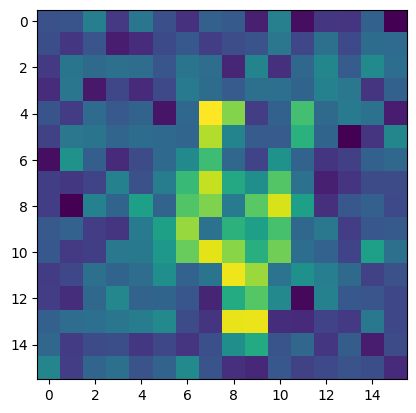

In [ ]:
# @title Sampling chatgpt

# def sample_reverse_time(model, num_samples=1000, timesteps=50, device='cpu'):
#     model.eval()
#     dt = 1.0 / timesteps
#     # x = torch.randn(num_samples, model.net[0].in_features - 1, device=device)
#     x = torch.randn(num_samples, 1,16,16, device=device)
#     for i in range(timesteps, 0, -1): # [timesteps,...,1]
#         t = torch.full((num_samples, 1), i * dt, device=device)  # Current time # [num_samples, 1] 1.

#         v = model(x, t)
#         x = x - dt * v # Euler update

#         # k1 = model(x, t)
#         # k2 = model(x - 0.5 * dt * k1, t - 0.5 * dt)
#         # k3 = model(x - 0.5 * dt * k2, t - 0.5 * dt)
#         # k4 = model(x - dt * k3, t - dt)
#         # x = x - (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4) # RK4 update

#     return x

from torchdiffeq import odeint # https://github.com/rtqichen/torchdiffeq
def sample_reverse_time(model, num_samples=1, timesteps=25, device='cpu'):
    # model.eval()
    # x_init = torch.randn(num_samples, model.net[0].in_features - 1, device=device)
    x_init = torch.randn(num_samples, 1,16,16, device=device)
    t_span = torch.tensor([1.0, 0.0], device=device)  # Reverse from t=1 to t=0
    # t_span = torch.linspace(1.0, 0.0, timesteps, device=device)  # Use timesteps to augment t_span
    # t_span = torch.cat([torch.rand(timesteps-1, device=device).sort()[0], torch.tensor([1.],device=device)])
    # print(t_span)
    x_samples = odeint(model, x_init, t_span, method='dopri5') # dopri5 euler rk4
    return x_samples[-1] # Final sampled data

# relative rtol and absolute atol error tolerance.
# RKAdaptiveStepsizeODESolver(func, y0, rtol, atol, min_step=0, max_step=float('inf'), first_step=None, step_t=None, jump_t=None, safety=0.9, ifactor=10.0, dfactor=0.2, max_num_steps=2 ** 31 - 1, dtype=torch.float64, **kwargs)
# https://github.com/rtqichen/torchdiffeq/blob/master/torchdiffeq/_impl/rk_common.py#L159

# https://github.com/rtqichen/torchdiffeq/blob/master/torchdiffeq/_impl/odeint.py#L36
# odeint(func, y0, t, *, rtol=1e-7, atol=1e-9, method=None, options=None, event_fn=None)



class Func(nn.Module):
    def __init__(self, model, cond):
        super().__init__()
        self.model = model
        self.cond = cond

    def forward(self, t, y):
        n_samples = y.shape[0]
        dydt = -self.model(y, t.repeat(n_samples), self.cond.repeat(n_samples,1)) # [n_samples, c,h,w], [n_samples], [n_samples, cond_dim]
        return dydt


# class ODEFunc(nn.Module): # https://github.com/rtqichen/torchdiffeq/blob/master/examples/ode_demo.py
#     def __init__(self):
#         super().__init__()
#         self.net = nn.Sequential()
#     def forward(self, t, y):
#         return self.net(y**3)
# # dy/dt = f(t, y)    y(t0) = y0
# pred_y = odeint(func, batch_y0, batch_t).to(device) # nn.Module, [batch, *img], [batch]


# cond = cond_emb(torch.tensor([4], device=device))
cond = F.one_hot(torch.tensor([4], device=device), num_classes=10).to(torch.float)

n_samples = 1
# sampled_data = sample_reverse_time(Func(model, cond), num_samples=n_samples, timesteps=25, device=device)
f = lambda t, y: -model(y, t.repeat(n_samples), cond.repeat(n_samples,1))
sampled_data = sample_reverse_time(f, num_samples=n_samples, timesteps=25, device=device)

import matplotlib.pyplot as plt
plt.imshow(sampled_data.detach().cpu().squeeze())
plt.show()



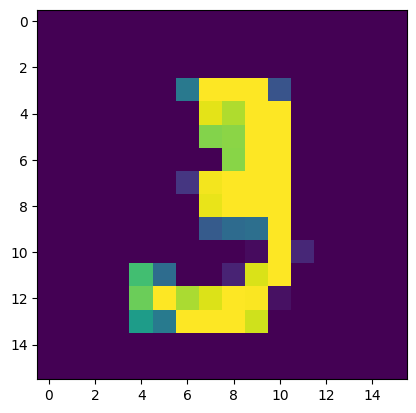

In [ ]:
# dataiter = iter(train_data)
x,y = next(dataiter)
# print(x.shape)
x=x.unsqueeze(0)
x1 = F.interpolate(x, size=(16,16))#.repeat(1,3,1,1)
plt.imshow(x1.squeeze())
plt.show()


In [ ]:
num_samples=1000
timesteps=5
dt = 1.0 / timesteps
for i in range(timesteps, 0, -1): # [timesteps,...,1]
    # print(i)
    t = torch.full((num_samples, 1), i * dt, device=device)  # Current time
    print(t)
    break
# [num_samples, 1] 1.


In [ ]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'

# modelsd, optimsd = torch.load(folder+'unet.pkl', map_location=device).values()
# model.load_state_dict(modelsd, strict=False)
# optim.load_state_dict(optimsd)


Mounted at /content/drive


In [ ]:
checkpoint = {'model': model.state_dict(), 'optimizer': optim.state_dict()}
torch.save(checkpoint, folder+'unetch16depth4.pkl')

In [ ]:
# @title Sampling lebellig
# https://github.com/lebellig/flow-matching/blob/main/Flow_Matching.ipynb
n_samples = 10_000
with torch.no_grad():
    x_0 = torch.randn(n_samples, 2, device=device)
    x_1_hat = v_t.decode(x_0)

import matplotlib.pyplot as plt
x_1_hat = x_1_hat.cpu().numpy()
plt.hist2d(x_1_hat[:, 0], x_1_hat[:, 1], bins=164)
plt.show()

# https://github.com/probabilists/zuko/blob/master/zuko/utils.py
def unpack(x: Tensor, shapes: Sequence[Size]) -> Sequence[Tensor]:
    r"""Unpacks a packed tensor.

    Arguments:
        x: A packed tensor, with shape :math:`(*, D)`.
        shapes: A sequence of shapes :math:`S_i`, corresponding to the total number of
            elements :math:`D`.

    Returns:
        The unpacked tensors, with shapes :math:`(*, S_i)`.

    Example:
        >>> x = torch.randn(26)
        >>> y, z = unpack(x, ((1, 2, 3), (4, 5)))
        >>> y.shape
        torch.Size([1, 2, 3])
        >>> z.shape
        torch.Size([4, 5])
    """

    sizes = [math.prod(s) for s in shapes]

    x = x.split(sizes, -1)
    x = (y.unflatten(-1, (*s, 1)) for y, s in zip(x, shapes))
    x = (y.squeeze(-1) for y in x)

    return tuple(x)

def odeint(
    f: Callable[[Tensor, Tensor], Tensor],
    x: Union[Tensor, Sequence[Tensor]],
    t0: Union[float, Tensor],
    t1: Union[float, Tensor],
    phi: Iterable[Tensor] = (),
    atol: float = 1e-6,
    rtol: float = 1e-5,
) -> Union[Tensor, Sequence[Tensor]]:
    r"""Integrates a system of first-order ordinary differential equations (ODEs)
    .. math:: \frac{dx}{dt} = f_\phi(t, x) ,
    from :math:`t_0` to :math:`t_1` using the adaptive Dormand-Prince method. The
    output is the final state
    .. math:: x(t_1) = x_0 + \int_{t_0}^{t_1} f_\phi(t, x(t)) ~ dt .
    Gradients are propagated through :math:`x_0`, :math:`t_0`, :math:`t_1` and
    :math:`\phi` via the adaptive checkpoint adjoint (ACA) method.
    References:
        | Neural Ordinary Differential Equations (Chen el al., 2018) | https://arxiv.org/abs/1806.07366
        | Adaptive Checkpoint Adjoint Method for Gradient Estimation in Neural ODE (Zhuang et al., 2020) | https://arxiv.org/abs/2006.02493

    Arguments:
        f: A system of first-order ODEs :math:`f_\phi`.
        x: The initial state :math:`x_0`.
        t0: The initial integration time :math:`t_0`.
        t1: The final integration time :math:`t_1`.
        phi: The parameters :math:`\phi` of :math:`f_\phi`.
        atol: The absolute tolerance.
        rtol: The relative tolerance.

    Returns: The final state :math:`x(t_1)`.

    Example:
        >>> A = torch.randn(3, 3)
        >>> f = lambda t, x: x @ A
        >>> x0 = torch.randn(3)
        >>> x1 = odeint(f, x0, 0.0, 1.0)
        >>> x1
        tensor([-1.4596,  0.5008,  1.5828])
    """

    settings = (atol, rtol, torch.is_grad_enabled())
    if torch.is_tensor(x):
        x0 = x
        g = f
    else: shapes = [y.shape for y in x]

        def pack(x: Iterable[Tensor]) -> Tensor:
            return torch.cat([y.flatten() for y in x])

        x0 = pack(x)
        g = lambda t, x: pack(f(t, *unpack(x, shapes)))

    t0 = torch.as_tensor(t0, dtype=x0.dtype, device=x0.device)
    t1 = torch.as_tensor(t1, dtype=x0.dtype, device=x0.device)

    assert not t0.shape and not t1.shape, "'t0' and 't1' must be scalars"

    x1 = AdaptiveCheckpointAdjoint.apply(settings, g, x0, t0, t1, *phi)

    if torch.is_tensor(x):
        return x1
    else:
        return unpack(x1, shapes)



def wrapper(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    t = t * torch.ones(len(x), device=x.device)
    return self(t, x)

from zuko.utils import odeint
def decode_t0_t1(self, x_0, t0, t1):
    return odeint(self.wrapper, x_0, t0, t1, self.parameters())


N_SAMPLES = 10_000
N_STEPS = 100
t_steps = torch.linspace(0, 1, N_STEPS, device=device)
with torch.no_grad():
    x_t = [torch.randn(n_samples, 2, device=device)]
    for t in range(len(t_steps)-1):
      x_t += [v_t.decode_t0_t1(x_t[-1], t_steps[t], t_steps[t+1])]

# pad predictions
x_t = [x_t[0]]*10 + x_t + [x_t[-1]] * 10

x_t_numpy = np.array([x.detach().cpu().numpy() for x in x_t])
filename = f"{DATASET}_{MODEL}_{N_SAMPLES}_{N_STEPS}.npy"
np.save(filename, x_t_numpy)






## save

In [ ]:
# @title lucidrains imagen
# https://github.com/lucidrains/imagen-pytorch/blob/main/imagen_pytorch/imagen_pytorch.py
# https://arxiv.org/pdf/2205.11487

import math
from random import random
from beartype.typing import List, Union, Optional
from beartype import beartype
from tqdm.auto import tqdm
from functools import partial, wraps
from contextlib import contextmanager, nullcontext
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel
from torch import nn, einsum
from torch.amp import autocast
from torch.special import expm1
import torchvision.transforms as T

import kornia.augmentation as K

from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange

from imagen_pytorch.t5 import t5_encode_text, get_encoded_dim, DEFAULT_T5_NAME

from imagen_pytorch.imagen_video import Unet3D, resize_video_to, scale_video_time

# helper functions

def exists(val):
    return val is not None

def identity(t, *args, **kwargs):
    return t

def divisible_by(numer, denom):
    return (numer % denom) == 0

def first(arr, d = None):
    if len(arr) == 0:
        return d
    return arr[0]

def maybe(fn):
    @wraps(fn)
    def inner(x):
        if not exists(x):
            return x
        return fn(x)
    return inner

def once(fn):
    called = False
    @wraps(fn)
    def inner(x):
        nonlocal called
        if called:
            return
        called = True
        return fn(x)
    return inner

print_once = once(print)

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def cast_tuple(val, length = None):
    if isinstance(val, list):
        val = tuple(val)

    output = val if isinstance(val, tuple) else ((val,) * default(length, 1))

    if exists(length):
        assert len(output) == length

    return output

def compact(input_dict):
    return {key: value for key, value in input_dict.items() if exists(value)}

def maybe_transform_dict_key(input_dict, key, fn):
    if key not in input_dict:
        return input_dict

    copied_dict = input_dict.copy()
    copied_dict[key] = fn(copied_dict[key])
    return copied_dict

def cast_uint8_images_to_float(images):
    if not images.dtype == torch.uint8:
        return images
    return images / 255

def module_device(module):
    return next(module.parameters()).device

def zero_init_(m):
    nn.init.zeros_(m.weight)
    if exists(m.bias):
        nn.init.zeros_(m.bias)

def eval_decorator(fn):
    def inner(model, *args, **kwargs):
        was_training = model.training
        model.eval()
        out = fn(model, *args, **kwargs)
        model.train(was_training)
        return out
    return inner

def pad_tuple_to_length(t, length, fillvalue = None):
    remain_length = length - len(t)
    if remain_length <= 0:
        return t
    return (*t, *((fillvalue,) * remain_length))

# helper classes

class Identity(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

    def forward(self, x, *args, **kwargs):
        return x

# tensor helpers

def log(t, eps: float = 1e-12):
    return torch.log(t.clamp(min = eps))

def l2norm(t):
    return F.normalize(t, dim = -1)

def right_pad_dims_to(x, t):
    padding_dims = x.ndim - t.ndim
    if padding_dims <= 0:
        return t
    return t.view(*t.shape, *((1,) * padding_dims))

def masked_mean(t, *, dim, mask = None):
    if not exists(mask):
        return t.mean(dim = dim)

    denom = mask.sum(dim = dim, keepdim = True)
    mask = rearrange(mask, 'b n -> b n 1')
    masked_t = t.masked_fill(~mask, 0.)

    return masked_t.sum(dim = dim) / denom.clamp(min = 1e-5)

def resize_image_to(
    image,
    target_image_size,
    clamp_range = None,
    mode = 'nearest'
):
    orig_image_size = image.shape[-1]

    if orig_image_size == target_image_size:
        return image

    out = F.interpolate(image, target_image_size, mode = mode)

    if exists(clamp_range):
        out = out.clamp(*clamp_range)

    return out

def calc_all_frame_dims(
    downsample_factors: List[int],
    frames
):
    if not exists(frames):
        return (tuple(),) * len(downsample_factors)

    all_frame_dims = []

    for divisor in downsample_factors:
        assert divisible_by(frames, divisor)
        all_frame_dims.append((frames // divisor,))

    return all_frame_dims

def safe_get_tuple_index(tup, index, default = None):
    if len(tup) <= index:
        return default
    return tup[index]

def pack_one_with_inverse(x, pattern):
    packed, packed_shape = pack([x], pattern)

    def inverse(x, inverse_pattern = None):
        inverse_pattern = default(inverse_pattern, pattern)
        return unpack(x, packed_shape, inverse_pattern)[0]

    return packed, inverse

# image normalization functions
# ddpms expect images to be in the range of -1 to 1

def normalize_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_zero_to_one(normed_img):
    return (normed_img + 1) * 0.5

# classifier free guidance functions

def prob_mask_like(shape, prob, device):
    if prob == 1:
        return torch.ones(shape, device = device, dtype = torch.bool)
    elif prob == 0:
        return torch.zeros(shape, device = device, dtype = torch.bool)
    else:
        return torch.zeros(shape, device = device).float().uniform_(0, 1) < prob

# for improved cfg, getting parallel and orthogonal components of cfg update

def project(x, y):
    x, inverse = pack_one_with_inverse(x, 'b *')
    y, _ = pack_one_with_inverse(y, 'b *')

    dtype = x.dtype
    x, y = x.double(), y.double()
    unit = F.normalize(y, dim = -1)

    parallel = (x * unit).sum(dim = -1, keepdim = True) * unit
    orthogonal = x - parallel

    return inverse(parallel).to(dtype), inverse(orthogonal).to(dtype)

# gaussian diffusion with continuous time helper functions and classes
# large part of this was thanks to @crowsonkb at https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/utils.py

@torch.jit.script
def beta_linear_log_snr(t):
    return -torch.log(expm1(1e-4 + 10 * (t ** 2)))

@torch.jit.script
def alpha_cosine_log_snr(t, s: float = 0.008):
    return -log((torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** -2) - 1, eps = 1e-5) # not sure if this accounts for beta being clipped to 0.999 in discrete version

def log_snr_to_alpha_sigma(log_snr):
    return torch.sqrt(torch.sigmoid(log_snr)), torch.sqrt(torch.sigmoid(-log_snr))

class GaussianDiffusionContinuousTimes(nn.Module):
    def __init__(self, *, noise_schedule, timesteps = 1000):
        super().__init__()

        if noise_schedule == "linear":
            self.log_snr = beta_linear_log_snr
        elif noise_schedule == "cosine":
            self.log_snr = alpha_cosine_log_snr
        else:
            raise ValueError(f'invalid noise schedule {noise_schedule}')

        self.num_timesteps = timesteps

    def get_times(self, batch_size, noise_level, *, device):
        return torch.full((batch_size,), noise_level, device = device, dtype = torch.float32)

    def sample_random_times(self, batch_size, *, device):
        return torch.zeros((batch_size,), device = device).float().uniform_(0, 1)

    def get_condition(self, times):
        return maybe(self.log_snr)(times)

    def get_sampling_timesteps(self, batch, *, device):
        times = torch.linspace(1., 0., self.num_timesteps + 1, device = device)
        times = repeat(times, 't -> b t', b = batch)
        times = torch.stack((times[:, :-1], times[:, 1:]), dim = 0)
        times = times.unbind(dim = -1)
        return times

    def q_posterior(self, x_start, x_t, t, *, t_next = None):
        t_next = default(t_next, lambda: (t - 1. / self.num_timesteps).clamp(min = 0.))

        """ https://openreview.net/attachment?id=2LdBqxc1Yv&name=supplementary_material """
        log_snr = self.log_snr(t)
        log_snr_next = self.log_snr(t_next)
        log_snr, log_snr_next = map(partial(right_pad_dims_to, x_t), (log_snr, log_snr_next))

        alpha, sigma = log_snr_to_alpha_sigma(log_snr)
        alpha_next, sigma_next = log_snr_to_alpha_sigma(log_snr_next)

        # c - as defined near eq 33
        c = -expm1(log_snr - log_snr_next)
        posterior_mean = alpha_next * (x_t * (1 - c) / alpha + c * x_start)

        # following (eq. 33)
        posterior_variance = (sigma_next ** 2) * c
        posterior_log_variance_clipped = log(posterior_variance, eps = 1e-20)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def q_sample(self, x_start, t, noise = None):
        dtype = x_start.dtype

        if isinstance(t, float):
            batch = x_start.shape[0]
            t = torch.full((batch,), t, device = x_start.device, dtype = dtype)

        noise = default(noise, lambda: torch.randn_like(x_start))
        log_snr = self.log_snr(t).type(dtype)
        log_snr_padded_dim = right_pad_dims_to(x_start, log_snr)
        alpha, sigma =  log_snr_to_alpha_sigma(log_snr_padded_dim)

        return alpha * x_start + sigma * noise, log_snr, alpha, sigma

    def q_sample_from_to(self, x_from, from_t, to_t, noise = None):
        shape, device, dtype = x_from.shape, x_from.device, x_from.dtype
        batch = shape[0]

        if isinstance(from_t, float):
            from_t = torch.full((batch,), from_t, device = device, dtype = dtype)

        if isinstance(to_t, float):
            to_t = torch.full((batch,), to_t, device = device, dtype = dtype)

        noise = default(noise, lambda: torch.randn_like(x_from))

        log_snr = self.log_snr(from_t)
        log_snr_padded_dim = right_pad_dims_to(x_from, log_snr)
        alpha, sigma =  log_snr_to_alpha_sigma(log_snr_padded_dim)

        log_snr_to = self.log_snr(to_t)
        log_snr_padded_dim_to = right_pad_dims_to(x_from, log_snr_to)
        alpha_to, sigma_to =  log_snr_to_alpha_sigma(log_snr_padded_dim_to)

        return x_from * (alpha_to / alpha) + noise * (sigma_to * alpha - sigma * alpha_to) / alpha

    def predict_start_from_v(self, x_t, t, v):
        log_snr = self.log_snr(t)
        log_snr = right_pad_dims_to(x_t, log_snr)
        alpha, sigma = log_snr_to_alpha_sigma(log_snr)
        return alpha * x_t - sigma * v

    def predict_start_from_noise(self, x_t, t, noise):
        log_snr = self.log_snr(t)
        log_snr = right_pad_dims_to(x_t, log_snr)
        alpha, sigma = log_snr_to_alpha_sigma(log_snr)
        return (x_t - sigma * noise) / alpha.clamp(min = 1e-8)

# norms and residuals

class ChanRMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.scale = dim ** 0.5
        self.gamma = nn.Parameter(torch.ones(dim, 1, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.scale * self.gamma

class LayerNorm(nn.Module):
    def __init__(self, feats, stable = False, dim = -1):
        super().__init__()
        self.stable = stable
        self.dim = dim

        self.g = nn.Parameter(torch.ones(feats, *((1,) * (-dim - 1))))

    def forward(self, x):
        dtype, dim = x.dtype, self.dim

        if self.stable:
            x = x / x.amax(dim = dim, keepdim = True).detach()

        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = dim, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = dim, keepdim = True)

        return (x - mean) * (var + eps).rsqrt().type(dtype) * self.g.type(dtype)

ChanLayerNorm = partial(LayerNorm, dim = -3)

class Always():
    def __init__(self, val):
        self.val = val

    def __call__(self, *args, **kwargs):
        return self.val

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class Parallel(nn.Module):
    def __init__(self, *fns):
        super().__init__()
        self.fns = nn.ModuleList(fns)

    def forward(self, x):
        outputs = [fn(x) for fn in self.fns]
        return sum(outputs)

# attention pooling

class PerceiverAttention(nn.Module):
    def __init__(
        self,
        *,
        dim,
        dim_head = 64,
        heads = 8,
        scale = 8
    ):
        super().__init__()
        self.scale = scale

        self.heads = heads
        inner_dim = dim_head * heads

        self.norm = nn.LayerNorm(dim)
        self.norm_latents = nn.LayerNorm(dim)

        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias = False)

        self.q_scale = nn.Parameter(torch.ones(dim_head))
        self.k_scale = nn.Parameter(torch.ones(dim_head))

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim, bias = False),
            nn.LayerNorm(dim)
        )

    def forward(self, x, latents, mask = None):
        x = self.norm(x)
        latents = self.norm_latents(latents)

        b, h = x.shape[0], self.heads

        q = self.to_q(latents)

        # the paper differs from Perceiver in which they also concat the key / values derived from the latents to be attended to
        kv_input = torch.cat((x, latents), dim = -2)
        k, v = self.to_kv(kv_input).chunk(2, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, k, v))

        # qk rmsnorm

        q, k = map(l2norm, (q, k))
        q = q * self.q_scale
        k = k * self.k_scale

        # similarities and masking

        sim = einsum('... i d, ... j d  -> ... i j', q, k) * self.scale

        if exists(mask):
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = F.pad(mask, (0, latents.shape[-2]), value = True)
            mask = rearrange(mask, 'b j -> b 1 1 j')
            sim = sim.masked_fill(~mask, max_neg_value)

        # attention

        attn = sim.softmax(dim = -1, dtype = torch.float32)
        attn = attn.to(sim.dtype)

        out = einsum('... i j, ... j d -> ... i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)', h = h)
        return self.to_out(out)

class PerceiverResampler(nn.Module):
    def __init__(
        self,
        *,
        dim,
        depth,
        dim_head = 64,
        heads = 8,
        num_latents = 64,
        num_latents_mean_pooled = 4, # number of latents derived from mean pooled representation of the sequence
        max_seq_len = 512,
        ff_mult = 4
    ):
        super().__init__()
        self.pos_emb = nn.Embedding(max_seq_len, dim)
        self.latents = nn.Parameter(torch.randn(num_latents, dim))
        self.to_latents_from_mean_pooled_seq = None
        if num_latents_mean_pooled > 0:
            self.to_latents_from_mean_pooled_seq = nn.Sequential(
                LayerNorm(dim),
                nn.Linear(dim, dim * num_latents_mean_pooled),
                Rearrange('b (n d) -> b n d', n = num_latents_mean_pooled)
            )

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PerceiverAttention(dim = dim, dim_head = dim_head, heads = heads),
                FeedForward(dim = dim, mult = ff_mult)
            ]))

    def forward(self, x, mask = None):
        n, device = x.shape[1], x.device
        pos_emb = self.pos_emb(torch.arange(n, device = device))

        x_with_pos = x + pos_emb

        latents = repeat(self.latents, 'n d -> b n d', b = x.shape[0])

        if exists(self.to_latents_from_mean_pooled_seq):
            meanpooled_seq = masked_mean(x, dim = 1, mask = torch.ones(x.shape[:2], device = x.device, dtype = torch.bool))
            meanpooled_latents = self.to_latents_from_mean_pooled_seq(meanpooled_seq)
            latents = torch.cat((meanpooled_latents, latents), dim = -2)

        for attn, ff in self.layers:
            latents = attn(x_with_pos, latents, mask = mask) + latents
            latents = ff(latents) + latents

        return latents

# attention

class Attention(nn.Module):
    def __init__(self, dim, *, dim_head = 64, heads = 8, context_dim = None, scale = 8):
        super().__init__()
        self.scale = scale
        self.heads = heads
        inner_dim = dim_head * heads
        self.norm = LayerNorm(dim)
        self.null_kv = nn.Parameter(torch.randn(2, dim_head))
        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, dim_head * 2, bias = False)

        self.q_scale = nn.Parameter(torch.ones(dim_head))
        self.k_scale = nn.Parameter(torch.ones(dim_head))
        self.to_context = nn.Sequential(nn.LayerNorm(context_dim), nn.Linear(context_dim, dim_head * 2)) if exists(context_dim) else None
        self.to_out = nn.Sequential(nn.Linear(inner_dim, dim, bias = False), LayerNorm(dim),)

    def forward(self, x, context = None, mask = None, attn_bias = None):
        b, n, device = *x.shape[:2], x.device
        x = self.norm(x)
        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = -1))
        q = rearrange(q, 'b n (h d) -> b h n d', h = self.heads)
        # add null key / value for classifier free guidance in prior net

        nk, nv = map(lambda t: repeat(t, 'd -> b 1 d', b = b), self.null_kv.unbind(dim = -2))
        k = torch.cat((nk, k), dim = -2)
        v = torch.cat((nv, v), dim = -2)

        # add text conditioning, if present
        if exists(context):
            assert exists(self.to_context)
            ck, cv = self.to_context(context).chunk(2, dim = -1)
            k = torch.cat((ck, k), dim = -2)
            v = torch.cat((cv, v), dim = -2)

        # qk rmsnorm
        q, k = map(l2norm, (q, k))
        q = q * self.q_scale
        k = k * self.k_scale
        # calculate query / key similarities
        sim = einsum('b h i d, b j d -> b h i j', q, k) * self.scale
        # relative positional encoding (T5 style)
        if exists(attn_bias): sim = sim + attn_bias

        # masking
        max_neg_value = -torch.finfo(sim.dtype).max

        if exists(mask):
            mask = F.pad(mask, (1, 0), value = True)
            mask = rearrange(mask, 'b j -> b 1 1 j')
            sim = sim.masked_fill(~mask, max_neg_value)

        # attention
        attn = sim.softmax(dim = -1, dtype = torch.float32)
        attn = attn.to(sim.dtype)

        # aggregate values
        out = einsum('b h i j, b j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

# decoder

def Upsample(dim, dim_out = None):
    dim_out = default(dim_out, dim)

    return nn.Sequential(nn.Upsample(scale_factor = 2, mode = 'nearest'), nn.Conv2d(dim, dim_out, 3, padding = 1))

class PixelShuffleUpsample(nn.Module):
    """
    code shared by @MalumaDev at DALLE2-pytorch for addressing checkboard artifacts
    https://arxiv.org/ftp/arxiv/papers/1707/1707.02937.pdf
    """
    def __init__(self, dim, dim_out = None):
        super().__init__()
        dim_out = default(dim_out, dim)
        conv = nn.Conv2d(dim, dim_out * 4, 1)
        self.net = nn.Sequential(conv, nn.SiLU(), nn.PixelShuffle(2))
        self.init_conv_(conv)

    def init_conv_(self, conv):
        o, i, h, w = conv.weight.shape
        conv_weight = torch.empty(o // 4, i, h, w)
        nn.init.kaiming_uniform_(conv_weight)
        conv_weight = repeat(conv_weight, 'o ... -> (o 4) ...')

        conv.weight.data.copy_(conv_weight)
        nn.init.zeros_(conv.bias.data)

    def forward(self, x):
        return self.net(x)

def Downsample(dim, dim_out = None):
    # https://arxiv.org/abs/2208.03641 shows this is the most optimal way to downsample
    # named SP-conv in the paper, but basically a pixel unshuffle
    dim_out = default(dim_out, dim)
    return nn.Sequential(
        Rearrange('b c (h s1) (w s2) -> b (c s1 s2) h w', s1 = 2, s2 = 2),
        nn.Conv2d(dim * 4, dim_out, 1)
    )

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device = x.device) * -emb)
        emb = rearrange(x, 'i -> i 1') * rearrange(emb, 'j -> 1 j')
        return torch.cat((emb.sin(), emb.cos()), dim = -1)

class LearnedSinusoidalPosEmb(nn.Module):
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """
    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

class Block(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        norm = True
    ):
        super().__init__()
        self.norm = ChanRMSNorm(dim) if norm else Identity()
        self.activation = nn.SiLU()
        self.project = nn.Conv2d(dim, dim_out, 3, padding = 1)

    def forward(self, x, scale_shift = None):
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.activation(x)
        return self.project(x)

class ResnetBlock(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        *,
        cond_dim = None,
        time_cond_dim = None,
        linear_attn = False,
        use_gca = False,
        squeeze_excite = False,
        **attn_kwargs
    ):
        super().__init__()
        self.time_mlp = None
        if exists(time_cond_dim):
            self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_cond_dim, dim_out * 2),)
        self.cross_attn = None
        if exists(cond_dim):
            attn_klass = CrossAttention if not linear_attn else LinearCrossAttention
            self.cross_attn = attn_klass(dim = dim_out, context_dim = cond_dim, **attn_kwargs)
        self.block1 = Block(dim, dim_out)
        self.block2 = Block(dim_out, dim_out)
        self.gca = GlobalContext(dim_in = dim_out, dim_out = dim_out) if use_gca else Always(1)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else Identity()

    def forward(self, x, time_emb = None, cond = None):

        scale_shift = None
        if exists(self.time_mlp) and exists(time_emb):
            time_emb = self.time_mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x)

        if exists(self.cross_attn):
            assert exists(cond)
            h = rearrange(h, 'b c h w -> b h w c')
            h, ps = pack([h], 'b * c')
            h = self.cross_attn(h, context = cond) + h
            h, = unpack(h, ps, 'b * c')
            h = rearrange(h, 'b h w c -> b c h w')

        h = self.block2(h, scale_shift = scale_shift)

        h = h * self.gca(h)

        return h + self.res_conv(x)

class CrossAttention(nn.Module):
    def __init__(
        self,
        dim,
        *,
        context_dim = None,
        dim_head = 64,
        heads = 8,
        norm_context = False,
        scale = 8
    ):
        super().__init__()
        self.scale = scale

        self.heads = heads
        inner_dim = dim_head * heads

        context_dim = default(context_dim, dim)

        self.norm = LayerNorm(dim)
        self.norm_context = LayerNorm(context_dim) if norm_context else Identity()

        self.null_kv = nn.Parameter(torch.randn(2, dim_head))
        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)

        self.q_scale = nn.Parameter(torch.ones(dim_head))
        self.k_scale = nn.Parameter(torch.ones(dim_head))

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim, bias = False), LayerNorm(dim)
        )

    def forward(self, x, context, mask = None):
        b, n, device = *x.shape[:2], x.device
        x = self.norm(x)
        context = self.norm_context(context)
        q, k, v = (self.to_q(x), *self.to_kv(context).chunk(2, dim = -1))
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), (q, k, v))
        # add null key / value for classifier free guidance in prior net
        nk, nv = map(lambda t: repeat(t, 'd -> b h 1 d', h = self.heads,  b = b), self.null_kv.unbind(dim = -2))
        k = torch.cat((nk, k), dim = -2)
        v = torch.cat((nv, v), dim = -2)

        # cosine sim attention

        q, k = map(l2norm, (q, k))
        q = q * self.q_scale
        k = k * self.k_scale

        # similarities

        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        # masking

        max_neg_value = -torch.finfo(sim.dtype).max

        if exists(mask):
            mask = F.pad(mask, (1, 0), value = True)
            mask = rearrange(mask, 'b j -> b 1 1 j')
            sim = sim.masked_fill(~mask, max_neg_value)

        attn = sim.softmax(dim = -1, dtype = torch.float32)
        attn = attn.to(sim.dtype)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class LinearCrossAttention(CrossAttention):
    def forward(self, x, context, mask = None):
        b, n, device = *x.shape[:2], x.device
        x = self.norm(x)
        context = self.norm_context(context)
        q, k, v = (self.to_q(x), *self.to_kv(context).chunk(2, dim = -1))
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = self.heads), (q, k, v))

        # add null key / value for classifier free guidance in prior net

        nk, nv = map(lambda t: repeat(t, 'd -> (b h) 1 d', h = self.heads,  b = b), self.null_kv.unbind(dim = -2))
        k = torch.cat((nk, k), dim = -2)
        v = torch.cat((nv, v), dim = -2)

        # masking

        max_neg_value = -torch.finfo(x.dtype).max

        if exists(mask):
            mask = F.pad(mask, (1, 0), value = True)
            mask = rearrange(mask, 'b n -> b n 1')
            k = k.masked_fill(~mask, max_neg_value)
            v = v.masked_fill(~mask, 0.)

        # linear attention

        q = q.softmax(dim = -1)
        k = k.softmax(dim = -2)
        q = q * self.scale
        context = einsum('b n d, b n e -> b d e', k, v)
        out = einsum('b n d, b d e -> b n e', q, context)
        out = rearrange(out, '(b h) n d -> b n (h d)', h = self.heads)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(
        self,
        dim,
        dim_head = 32,
        heads = 8,
        dropout = 0.05,
        context_dim = None,
        **kwargs
    ):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads
        self.norm = ChanLayerNorm(dim)

        self.nonlin = nn.SiLU()

        self.to_q = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(dim, inner_dim, 1, bias = False),
            nn.Conv2d(inner_dim, inner_dim, 3, bias = False, padding = 1, groups = inner_dim)
        )

        self.to_k = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(dim, inner_dim, 1, bias = False),
            nn.Conv2d(inner_dim, inner_dim, 3, bias = False, padding = 1, groups = inner_dim)
        )

        self.to_v = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(dim, inner_dim, 1, bias = False),
            nn.Conv2d(inner_dim, inner_dim, 3, bias = False, padding = 1, groups = inner_dim)
        )

        self.to_context = nn.Sequential(nn.LayerNorm(context_dim), nn.Linear(context_dim, inner_dim * 2, bias = False)) if exists(context_dim) else None

        self.to_out = nn.Sequential(
            nn.Conv2d(inner_dim, dim, 1, bias = False),
            ChanLayerNorm(dim)
        )

    def forward(self, fmap, context = None):
        h, x, y = self.heads, *fmap.shape[-2:]

        fmap = self.norm(fmap)
        q, k, v = map(lambda fn: fn(fmap), (self.to_q, self.to_k, self.to_v))
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> (b h) (x y) c', h = h), (q, k, v))

        if exists(context):
            assert exists(self.to_context)
            ck, cv = self.to_context(context).chunk(2, dim = -1)
            ck, cv = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (ck, cv))
            k = torch.cat((k, ck), dim = -2)
            v = torch.cat((v, cv), dim = -2)

        q = q.softmax(dim = -1)
        k = k.softmax(dim = -2)

        q = q * self.scale

        context = einsum('b n d, b n e -> b d e', k, v)
        out = einsum('b n d, b d e -> b n e', q, context)
        out = rearrange(out, '(b h) (x y) d -> b (h d) x y', h = h, x = x, y = y)

        out = self.nonlin(out)
        return self.to_out(out)

class GlobalContext(nn.Module):
    """ basically a superior form of squeeze-excitation that is attention-esque """

    def __init__(
        self,
        *,
        dim_in,
        dim_out
    ):
        super().__init__()
        self.to_k = nn.Conv2d(dim_in, 1, 1)
        hidden_dim = max(3, dim_out // 2)

        self.net = nn.Sequential(
            nn.Conv2d(dim_in, hidden_dim, 1),
            nn.SiLU(),
            nn.Conv2d(hidden_dim, dim_out, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        context = self.to_k(x)
        x, context = map(lambda t: rearrange(t, 'b n ... -> b n (...)'), (x, context))
        out = einsum('b i n, b c n -> b c i', context.softmax(dim = -1), x)
        out = rearrange(out, '... -> ... 1')
        return self.net(out)

def FeedForward(dim, mult = 2):
    hidden_dim = int(dim * mult)
    return nn.Sequential(
        LayerNorm(dim),
        nn.Linear(dim, hidden_dim, bias = False),
        nn.GELU(),
        LayerNorm(hidden_dim),
        nn.Linear(hidden_dim, dim, bias = False)
    )

def ChanFeedForward(dim, mult = 2):  # in paper, it seems for self attention layers they did feedforwards with twice channel width
    hidden_dim = int(dim * mult)
    return nn.Sequential(
        ChanLayerNorm(dim),
        nn.Conv2d(dim, hidden_dim, 1, bias = False),
        nn.GELU(),
        ChanLayerNorm(hidden_dim),
        nn.Conv2d(hidden_dim, dim, 1, bias = False)
    )

class TransformerBlock(nn.Module):
    def __init__(
        self,
        dim,
        *,
        depth = 1,
        heads = 8,
        dim_head = 32,
        ff_mult = 2,
        context_dim = None
    ):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim = dim, heads = heads, dim_head = dim_head, context_dim = context_dim),
                FeedForward(dim = dim, mult = ff_mult)
            ]))

    def forward(self, x, context = None):
        x = rearrange(x, 'b c h w -> b h w c')
        x, ps = pack([x], 'b * c')

        for attn, ff in self.layers:
            x = attn(x, context = context) + x
            x = ff(x) + x

        x, = unpack(x, ps, 'b * c')
        x = rearrange(x, 'b h w c -> b c h w')
        return x

class LinearAttentionTransformerBlock(nn.Module):
    def __init__(
        self,
        dim,
        *,
        depth = 1,
        heads = 8,
        dim_head = 32,
        ff_mult = 2,
        context_dim = None,
        **kwargs
    ):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                LinearAttention(dim = dim, heads = heads, dim_head = dim_head, context_dim = context_dim),
                ChanFeedForward(dim = dim, mult = ff_mult)
            ]))

    def forward(self, x, context = None):
        for attn, ff in self.layers:
            x = attn(x, context = context) + x
            x = ff(x) + x
        return x

class CrossEmbedLayer(nn.Module):
    def __init__(
        self,
        dim_in,
        kernel_sizes,
        dim_out = None,
        stride = 2
    ):
        super().__init__()
        assert all([*map(lambda t: (t % 2) == (stride % 2), kernel_sizes)])
        dim_out = default(dim_out, dim_in)

        kernel_sizes = sorted(kernel_sizes)
        num_scales = len(kernel_sizes)

        # calculate the dimension at each scale
        dim_scales = [int(dim_out / (2 ** i)) for i in range(1, num_scales)]
        dim_scales = [*dim_scales, dim_out - sum(dim_scales)]

        self.convs = nn.ModuleList([])
        for kernel, dim_scale in zip(kernel_sizes, dim_scales):
            self.convs.append(nn.Conv2d(dim_in, dim_scale, kernel, stride = stride, padding = (kernel - stride) // 2))

    def forward(self, x):
        fmaps = tuple(map(lambda conv: conv(x), self.convs))
        return torch.cat(fmaps, dim = 1)

class UpsampleCombiner(nn.Module):
    def __init__(
        self,
        dim,
        *,
        enabled = False,
        dim_ins = tuple(),
        dim_outs = tuple()
    ):
        super().__init__()
        dim_outs = cast_tuple(dim_outs, len(dim_ins))
        assert len(dim_ins) == len(dim_outs)

        self.enabled = enabled

        if not self.enabled:
            self.dim_out = dim
            return

        self.fmap_convs = nn.ModuleList([Block(dim_in, dim_out) for dim_in, dim_out in zip(dim_ins, dim_outs)])
        self.dim_out = dim + (sum(dim_outs) if len(dim_outs) > 0 else 0)

    def forward(self, x, fmaps = None):
        target_size = x.shape[-1]

        fmaps = default(fmaps, tuple())

        if not self.enabled or len(fmaps) == 0 or len(self.fmap_convs) == 0:
            return x

        fmaps = [resize_image_to(fmap, target_size) for fmap in fmaps]
        outs = [conv(fmap) for fmap, conv in zip(fmaps, self.fmap_convs)]
        return torch.cat((x, *outs), dim = 1)

class Unet(nn.Module):
    def __init__(
        self,
        *,
        dim,
        text_embed_dim = get_encoded_dim(DEFAULT_T5_NAME),
        num_resnet_blocks = 1,
        cond_dim = None,
        num_image_tokens = 4,
        num_time_tokens = 2,
        learned_sinu_pos_emb_dim = 16,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        cond_images_channels = 0,
        channels = 3,
        channels_out = None,
        attn_dim_head = 64,
        attn_heads = 8,
        ff_mult = 2.,
        lowres_cond = False,                # for cascading diffusion - https://cascaded-diffusion.github.io/
        layer_attns = True,
        layer_attns_depth = 1,
        layer_mid_attns_depth = 1,
        layer_attns_add_text_cond = True,   # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
        attend_at_middle = True,            # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
        layer_cross_attns = True,
        use_linear_attn = False,
        use_linear_cross_attn = False,
        cond_on_text = True,
        max_text_len = 256,
        init_dim = None,
        init_conv_kernel_size = 7,          # kernel size of initial conv, if not using cross embed
        init_cross_embed = True,
        init_cross_embed_kernel_sizes = (3, 7, 15),
        cross_embed_downsample = False,
        cross_embed_downsample_kernel_sizes = (2, 4),
        attn_pool_text = True,
        attn_pool_num_latents = 32,
        dropout = 0.,
        memory_efficient = False,
        init_conv_to_final_conv_residual = False,
        use_global_context_attn = True,
        scale_skip_connection = True,
        final_resnet_block = True,
        final_conv_kernel_size = 3,
        self_cond = False,
        resize_mode = 'nearest',
        combine_upsample_fmaps = False,      # combine feature maps from all upsample blocks, used in unet squared successfully
        pixel_shuffle_upsample = True,       # may address checkboard artifacts
    ):
        super().__init__()

        # guide researchers

        assert attn_heads > 1, 'you need to have more than 1 attention head, ideally at least 4 or 8'

        if dim < 128:
            print_once('The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/')

        # save locals to take care of some hyperparameters for cascading DDPM

        self._locals = locals()
        self._locals.pop('self', None)
        self._locals.pop('__class__', None)

        # determine dimensions

        self.channels = channels
        self.channels_out = default(channels_out, channels)

        # (1) in cascading diffusion, one concats the low resolution image, blurred, for conditioning the higher resolution synthesis
        # (2) in self conditioning, one appends the predict x0 (x_start)
        init_channels = channels * (1 + int(lowres_cond) + int(self_cond))
        init_dim = default(init_dim, dim)

        self.self_cond = self_cond

        # optional image conditioning

        self.has_cond_image = cond_images_channels > 0
        self.cond_images_channels = cond_images_channels

        init_channels += cond_images_channels

        # initial convolution

        self.init_conv = CrossEmbedLayer(init_channels, dim_out = init_dim, kernel_sizes = init_cross_embed_kernel_sizes, stride = 1) if init_cross_embed else nn.Conv2d(init_channels, init_dim, init_conv_kernel_size, padding = init_conv_kernel_size // 2)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # time conditioning

        cond_dim = default(cond_dim, dim)
        time_cond_dim = dim * 4 * (2 if lowres_cond else 1)

        # embedding time for log(snr) noise from continuous version

        sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinu_pos_emb_dim)
        sinu_pos_emb_input_dim = learned_sinu_pos_emb_dim + 1

        self.to_time_hiddens = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(sinu_pos_emb_input_dim, time_cond_dim),
            nn.SiLU()
        )

        self.to_time_cond = nn.Sequential(
            nn.Linear(time_cond_dim, time_cond_dim)
        )

        # project to time tokens as well as time hiddens

        self.to_time_tokens = nn.Sequential(
            nn.Linear(time_cond_dim, cond_dim * num_time_tokens),
            Rearrange('b (r d) -> b r d', r = num_time_tokens)
        )

        # low res aug noise conditioning

        self.lowres_cond = lowres_cond

        if lowres_cond:
            self.to_lowres_time_hiddens = nn.Sequential(
                LearnedSinusoidalPosEmb(learned_sinu_pos_emb_dim),
                nn.Linear(learned_sinu_pos_emb_dim + 1, time_cond_dim),
                nn.SiLU()
            )

            self.to_lowres_time_cond = nn.Sequential(
                nn.Linear(time_cond_dim, time_cond_dim)
            )

            self.to_lowres_time_tokens = nn.Sequential(
                nn.Linear(time_cond_dim, cond_dim * num_time_tokens),
                Rearrange('b (r d) -> b r d', r = num_time_tokens)
            )

        # normalizations

        self.norm_cond = nn.LayerNorm(cond_dim)

        # text encoding conditioning (optional)

        self.text_to_cond = None

        if cond_on_text:
            assert exists(text_embed_dim), 'text_embed_dim must be given to the unet if cond_on_text is True'
            self.text_to_cond = nn.Linear(text_embed_dim, cond_dim)

        # finer control over whether to condition on text encodings

        self.cond_on_text = cond_on_text

        # attention pooling

        self.attn_pool = PerceiverResampler(dim = cond_dim, depth = 2, dim_head = attn_dim_head, heads = attn_heads, num_latents = attn_pool_num_latents) if attn_pool_text else None

        # for classifier free guidance

        self.max_text_len = max_text_len

        self.null_text_embed = nn.Parameter(torch.randn(1, max_text_len, cond_dim))
        self.null_text_hidden = nn.Parameter(torch.randn(1, time_cond_dim))

        # for non-attention based text conditioning at all points in the network where time is also conditioned

        self.to_text_non_attn_cond = None

        if cond_on_text:
            self.to_text_non_attn_cond = nn.Sequential(
                nn.LayerNorm(cond_dim),
                nn.Linear(cond_dim, time_cond_dim),
                nn.SiLU(),
                nn.Linear(time_cond_dim, time_cond_dim)
            )

        # attention related params

        attn_kwargs = dict(heads = attn_heads, dim_head = attn_dim_head)

        num_layers = len(in_out)

        # resnet block klass

        num_resnet_blocks = cast_tuple(num_resnet_blocks, num_layers)

        resnet_klass = partial(ResnetBlock, **attn_kwargs)

        layer_attns = cast_tuple(layer_attns, num_layers)
        layer_attns_depth = cast_tuple(layer_attns_depth, num_layers)
        layer_cross_attns = cast_tuple(layer_cross_attns, num_layers)

        use_linear_attn = cast_tuple(use_linear_attn, num_layers)
        use_linear_cross_attn = cast_tuple(use_linear_cross_attn, num_layers)

        assert all([layers == num_layers for layers in list(map(len, (layer_attns, layer_cross_attns)))])

        # downsample klass

        downsample_klass = Downsample

        if cross_embed_downsample:
            downsample_klass = partial(CrossEmbedLayer, kernel_sizes = cross_embed_downsample_kernel_sizes)

        # initial resnet block (for memory efficient unet)

        self.init_resnet_block = resnet_klass(init_dim, init_dim, time_cond_dim = time_cond_dim, use_gca = use_global_context_attn) if memory_efficient else None

        # scale for resnet skip connections

        self.skip_connect_scale = 1. if not scale_skip_connection else (2 ** -0.5)

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        layer_params = [num_resnet_blocks, layer_attns, layer_attns_depth, layer_cross_attns, use_linear_attn, use_linear_cross_attn]
        reversed_layer_params = list(map(reversed, layer_params))

        # downsampling layers

        skip_connect_dims = [] # keep track of skip connection dimensions

        for ind, ((dim_in, dim_out), layer_num_resnet_blocks, layer_attn, layer_attn_depth, layer_cross_attn, layer_use_linear_attn, layer_use_linear_cross_attn) in enumerate(zip(in_out, *layer_params)):
            is_last = ind >= (num_resolutions - 1)

            layer_cond_dim = cond_dim if layer_cross_attn or layer_use_linear_cross_attn else None

            if layer_attn:
                transformer_block_klass = TransformerBlock
            elif layer_use_linear_attn:
                transformer_block_klass = LinearAttentionTransformerBlock
            else:
                transformer_block_klass = Identity

            current_dim = dim_in

            # whether to pre-downsample, from memory efficient unet

            pre_downsample = None

            if memory_efficient:
                pre_downsample = downsample_klass(dim_in, dim_out)
                current_dim = dim_out

            skip_connect_dims.append(current_dim)

            # whether to do post-downsample, for non-memory efficient unet

            post_downsample = None
            if not memory_efficient:
                post_downsample = downsample_klass(current_dim, dim_out) if not is_last else Parallel(nn.Conv2d(dim_in, dim_out, 3, padding = 1), nn.Conv2d(dim_in, dim_out, 1))

            self.downs.append(nn.ModuleList([
                pre_downsample,
                resnet_klass(current_dim, current_dim, cond_dim = layer_cond_dim, linear_attn = layer_use_linear_cross_attn, time_cond_dim = time_cond_dim),
                nn.ModuleList([ResnetBlock(current_dim, current_dim, time_cond_dim = time_cond_dim, use_gca = use_global_context_attn) for _ in range(layer_num_resnet_blocks)]),
                transformer_block_klass(dim = current_dim, depth = layer_attn_depth, ff_mult = ff_mult, context_dim = cond_dim, **attn_kwargs),
                post_downsample
            ]))

        # middle layers

        mid_dim = dims[-1]

        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, cond_dim = cond_dim, time_cond_dim = time_cond_dim)
        self.mid_attn = TransformerBlock(mid_dim, depth = layer_mid_attns_depth, **attn_kwargs) if attend_at_middle else None
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, cond_dim = cond_dim, time_cond_dim = time_cond_dim)

        # upsample klass

        upsample_klass = Upsample if not pixel_shuffle_upsample else PixelShuffleUpsample

        # upsampling layers

        upsample_fmap_dims = []

        for ind, ((dim_in, dim_out), layer_num_resnet_blocks, layer_attn, layer_attn_depth, layer_cross_attn, layer_use_linear_attn, layer_use_linear_cross_attn) in enumerate(zip(reversed(in_out), *reversed_layer_params)):
            is_last = ind == (len(in_out) - 1)

            layer_cond_dim = cond_dim if layer_cross_attn or layer_use_linear_cross_attn else None

            if layer_attn:
                transformer_block_klass = TransformerBlock
            elif layer_use_linear_attn:
                transformer_block_klass = LinearAttentionTransformerBlock
            else:
                transformer_block_klass = Identity

            skip_connect_dim = skip_connect_dims.pop()

            upsample_fmap_dims.append(dim_out)

            self.ups.append(nn.ModuleList([
                resnet_klass(dim_out + skip_connect_dim, dim_out, cond_dim = layer_cond_dim, linear_attn = layer_use_linear_cross_attn, time_cond_dim = time_cond_dim),
                nn.ModuleList([ResnetBlock(dim_out + skip_connect_dim, dim_out, time_cond_dim = time_cond_dim, use_gca = use_global_context_attn) for _ in range(layer_num_resnet_blocks)]),
                transformer_block_klass(dim = dim_out, depth = layer_attn_depth, ff_mult = ff_mult, context_dim = cond_dim, **attn_kwargs),
                upsample_klass(dim_out, dim_in) if not is_last or memory_efficient else Identity()
            ]))

        # whether to combine feature maps from all upsample blocks before final resnet block out

        self.upsample_combiner = UpsampleCombiner(
            dim = dim,
            enabled = combine_upsample_fmaps,
            dim_ins = upsample_fmap_dims,
            dim_outs = dim
        )

        # whether to do a final residual from initial conv to the final resnet block out

        self.init_conv_to_final_conv_residual = init_conv_to_final_conv_residual
        final_conv_dim = self.upsample_combiner.dim_out + (dim if init_conv_to_final_conv_residual else 0)

        # final optional resnet block and convolution out

        self.final_res_block = ResnetBlock(final_conv_dim, dim, time_cond_dim = time_cond_dim, use_gca = True) if final_resnet_block else None

        final_conv_dim_in = dim if final_resnet_block else final_conv_dim
        final_conv_dim_in += (channels if lowres_cond else 0)

        self.final_conv = nn.Conv2d(final_conv_dim_in, self.channels_out, final_conv_kernel_size, padding = final_conv_kernel_size // 2)

        zero_init_(self.final_conv)

        # resize mode

        self.resize_mode = resize_mode


    # forward with classifier free guidance

    def forward_with_cond_scale(
        self,
        *args,
        cond_scale = 1.,
        remove_parallel_component = True,
        keep_parallel_frac = 0.,
        **kwargs
    ):
        logits = self.forward(*args, **kwargs)

        if cond_scale == 1:
            return logits

        null_logits = self.forward(*args, cond_drop_prob = 1., **kwargs)

        update = (logits - null_logits)

        if remove_parallel_component:
            parallel, orthogonal = project(update, logits)
            update = orthogonal + parallel * keep_parallel_frac

        return logits + update * (cond_scale - 1)

    def forward(
        self,
        x,
        time,
        *,
        lowres_cond_img = None,
        lowres_noise_times = None,
        text_embeds = None,
        text_mask = None,
        cond_images = None,
        self_cond = None,
        cond_drop_prob = 0.
    ):
        batch_size, device = x.shape[0], x.device

        # condition on self

        if self.self_cond:
            self_cond = default(self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x, self_cond), dim = 1)

        # add low resolution conditioning, if present

        assert not (self.lowres_cond and not exists(lowres_cond_img)), 'low resolution conditioning image must be present'
        assert not (self.lowres_cond and not exists(lowres_noise_times)), 'low resolution conditioning noise time must be present'

        if exists(lowres_cond_img):
            x = torch.cat((x, lowres_cond_img), dim = 1)

        # condition on input image

        assert not (self.has_cond_image ^ exists(cond_images)), 'you either requested to condition on an image on the unet, but the conditioning image is not supplied, or vice versa'

        if exists(cond_images):
            assert cond_images.shape[1] == self.cond_images_channels, 'the number of channels on the conditioning image you are passing in does not match what you specified on initialiation of the unet'
            cond_images = resize_image_to(cond_images, x.shape[-1], mode = self.resize_mode)
            x = torch.cat((cond_images, x), dim = 1)

        # initial convolution

        x = self.init_conv(x)

        # init conv residual

        if self.init_conv_to_final_conv_residual:
            init_conv_residual = x.clone()

        # time conditioning

        time_hiddens = self.to_time_hiddens(time)

        # derive time tokens

        time_tokens = self.to_time_tokens(time_hiddens)
        t = self.to_time_cond(time_hiddens)

        # add lowres time conditioning to time hiddens
        # and add lowres time tokens along sequence dimension for attention

        if self.lowres_cond:
            lowres_time_hiddens = self.to_lowres_time_hiddens(lowres_noise_times)
            lowres_time_tokens = self.to_lowres_time_tokens(lowres_time_hiddens)
            lowres_t = self.to_lowres_time_cond(lowres_time_hiddens)

            t = t + lowres_t
            time_tokens = torch.cat((time_tokens, lowres_time_tokens), dim = -2)

        # text conditioning

        text_tokens = None

        if exists(text_embeds) and self.cond_on_text:

            # conditional dropout

            text_keep_mask = prob_mask_like((batch_size,), 1 - cond_drop_prob, device = device)

            text_keep_mask_embed = rearrange(text_keep_mask, 'b -> b 1 1')
            text_keep_mask_hidden = rearrange(text_keep_mask, 'b -> b 1')

            # calculate text embeds

            text_tokens = self.text_to_cond(text_embeds)

            text_tokens = text_tokens[:, :self.max_text_len]

            if exists(text_mask):
                text_mask = text_mask[:, :self.max_text_len]

            text_tokens_len = text_tokens.shape[1]
            remainder = self.max_text_len - text_tokens_len

            if remainder > 0:
                text_tokens = F.pad(text_tokens, (0, 0, 0, remainder))

            if exists(text_mask):
                if remainder > 0:
                    text_mask = F.pad(text_mask, (0, remainder), value = False)

                text_mask = rearrange(text_mask, 'b n -> b n 1')
                text_keep_mask_embed = text_mask & text_keep_mask_embed

            null_text_embed = self.null_text_embed.to(text_tokens.dtype) # for some reason pytorch AMP not working

            text_tokens = torch.where(
                text_keep_mask_embed,
                text_tokens,
                null_text_embed
            )

            if exists(self.attn_pool):
                text_tokens = self.attn_pool(text_tokens)

            # extra non-attention conditioning by projecting and then summing text embeddings to time
            # termed as text hiddens

            mean_pooled_text_tokens = text_tokens.mean(dim = -2)

            text_hiddens = self.to_text_non_attn_cond(mean_pooled_text_tokens)

            null_text_hidden = self.null_text_hidden.to(t.dtype)

            text_hiddens = torch.where(
                text_keep_mask_hidden,
                text_hiddens,
                null_text_hidden
            )

            t = t + text_hiddens

        # main conditioning tokens (c)

        c = time_tokens if not exists(text_tokens) else torch.cat((time_tokens, text_tokens), dim = -2)

        # normalize conditioning tokens

        c = self.norm_cond(c)

        # initial resnet block (for memory efficient unet)

        if exists(self.init_resnet_block):
            x = self.init_resnet_block(x, t)

        # go through the layers of the unet, down and up

        hiddens = []

        for pre_downsample, init_block, resnet_blocks, attn_block, post_downsample in self.downs:
            if exists(pre_downsample):
                x = pre_downsample(x)

            x = init_block(x, t, c)

            for resnet_block in resnet_blocks:
                x = resnet_block(x, t)
                hiddens.append(x)

            x = attn_block(x, c)
            hiddens.append(x)

            if exists(post_downsample):
                x = post_downsample(x)

        x = self.mid_block1(x, t, c)

        if exists(self.mid_attn):
            x = self.mid_attn(x)

        x = self.mid_block2(x, t, c)

        add_skip_connection = lambda x: torch.cat((x, hiddens.pop() * self.skip_connect_scale), dim = 1)

        up_hiddens = []

        for init_block, resnet_blocks, attn_block, upsample in self.ups:
            x = add_skip_connection(x)
            x = init_block(x, t, c)

            for resnet_block in resnet_blocks:
                x = add_skip_connection(x)
                x = resnet_block(x, t)

            x = attn_block(x, c)
            up_hiddens.append(x.contiguous())
            x = upsample(x)

        # whether to combine all feature maps from upsample blocks

        x = self.upsample_combiner(x, up_hiddens)

        # final top-most residual if needed

        if self.init_conv_to_final_conv_residual:
            x = torch.cat((x, init_conv_residual), dim = 1)

        if exists(self.final_res_block):
            x = self.final_res_block(x, t)

        if exists(lowres_cond_img):
            x = torch.cat((x, lowres_cond_img), dim = 1)

        return self.final_conv(x)

# null unet

class NullUnet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.lowres_cond = False
        self.dummy_parameter = nn.Parameter(torch.tensor([0.]))

    def cast_model_parameters(self, *args, **kwargs):
        return self

    def forward(self, x, *args, **kwargs):
        return x

# predefined unets, with configs lining up with hyperparameters in appendix of paper

class BaseUnet64(Unet):
    def __init__(self, *args, **kwargs):
        default_kwargs = dict(
            dim = 512,
            dim_mults = (1, 2, 3, 4),
            num_resnet_blocks = 3,
            layer_attns = (False, True, True, True),
            layer_cross_attns = (False, True, True, True),
            attn_heads = 8,
            ff_mult = 2.,
            memory_efficient = False
        )
        super().__init__(*args, **{**default_kwargs, **kwargs})

class SRUnet256(Unet):
    def __init__(self, *args, **kwargs):
        default_kwargs = dict(
            dim = 128,
            dim_mults = (1, 2, 4, 8),
            num_resnet_blocks = (2, 4, 8, 8),
            layer_attns = (False, False, False, True),
            layer_cross_attns = (False, False, False, True),
            attn_heads = 8,
            ff_mult = 2.,
            memory_efficient = True
        )
        super().__init__(*args, **{**default_kwargs, **kwargs})

class SRUnet1024(Unet):
    def __init__(self, *args, **kwargs):
        default_kwargs = dict(
            dim = 128,
            dim_mults = (1, 2, 4, 8),
            num_resnet_blocks = (2, 4, 8, 8),
            layer_attns = False,
            layer_cross_attns = (False, False, False, True),
            attn_heads = 8,
            ff_mult = 2.,
            memory_efficient = True
        )
        super().__init__(*args, **{**default_kwargs, **kwargs})

# main imagen ddpm class, which is a cascading DDPM from Ho et al.

class Imagen(nn.Module):
    def __init__(
        self,
        unets,
        *,
        image_sizes,                                # for cascading ddpm, image size at each stage
        text_encoder_name = DEFAULT_T5_NAME,
        text_embed_dim = None,
        channels = 3,
        timesteps = 1000,
        cond_drop_prob = 0.1,
        loss_type = 'l2',
        noise_schedules = 'cosine',
        pred_objectives = 'noise',
        random_crop_sizes = None,
        lowres_noise_schedule = 'linear',
        lowres_sample_noise_level = 0.2,            # in the paper, they present a new trick where they noise the lowres conditioning image, and at sample time, fix it to a certain level (0.1 or 0.3) - the unets are also made to be conditioned on this noise level
        per_sample_random_aug_noise_level = False,  # unclear when conditioning on augmentation noise level, whether each batch element receives a random aug noise value - turning off due to @marunine's find
        condition_on_text = True,
        auto_normalize_img = True,                  # whether to take care of normalizing the image from [0, 1] to [-1, 1] and back automatically - you can turn this off if you want to pass in the [-1, 1] ranged image yourself from the dataloader
        dynamic_thresholding = True,
        dynamic_thresholding_percentile = 0.95,     # unsure what this was based on perusal of paper
        only_train_unet_number = None,
        temporal_downsample_factor = 1,
        resize_cond_video_frames = True,
        resize_mode = 'nearest',
        min_snr_loss_weight = True,                 # https://arxiv.org/abs/2303.09556
        min_snr_gamma = 5
    ):
        super().__init__()

        # loss

        if loss_type == 'l1':
            loss_fn = F.l1_loss
        elif loss_type == 'l2':
            loss_fn = F.mse_loss
        elif loss_type == 'huber':
            loss_fn = F.smooth_l1_loss

        self.loss_type = loss_type
        self.loss_fn = loss_fn

        # conditioning hparams

        self.condition_on_text = condition_on_text
        self.unconditional = not condition_on_text

        # channels

        self.channels = channels

        # automatically take care of ensuring that first unet is unconditional
        # while the rest of the unets are conditioned on the low resolution image produced by previous unet

        unets = cast_tuple(unets)
        num_unets = len(unets)

        # determine noise schedules per unet

        timesteps = cast_tuple(timesteps, num_unets)

        # make sure noise schedule defaults to 'cosine', 'cosine', and then 'linear' for rest of super-resoluting unets

        noise_schedules = cast_tuple(noise_schedules)
        noise_schedules = pad_tuple_to_length(noise_schedules, 2, 'cosine')
        noise_schedules = pad_tuple_to_length(noise_schedules, num_unets, 'linear')

        # construct noise schedulers

        noise_scheduler_klass = GaussianDiffusionContinuousTimes
        self.noise_schedulers = nn.ModuleList([])

        for timestep, noise_schedule in zip(timesteps, noise_schedules):
            noise_scheduler = noise_scheduler_klass(noise_schedule = noise_schedule, timesteps = timestep)
            self.noise_schedulers.append(noise_scheduler)

        # randomly cropping for upsampler training

        self.random_crop_sizes = cast_tuple(random_crop_sizes, num_unets)
        assert not exists(first(self.random_crop_sizes)), 'you should not need to randomly crop image during training for base unet, only for upsamplers - so pass in `random_crop_sizes = (None, 128, 256)` as example'

        # lowres augmentation noise schedule

        self.lowres_noise_schedule = GaussianDiffusionContinuousTimes(noise_schedule = lowres_noise_schedule)

        # ddpm objectives - predicting noise by default

        self.pred_objectives = cast_tuple(pred_objectives, num_unets)

        # get text encoder

        self.text_encoder_name = text_encoder_name
        self.text_embed_dim = default(text_embed_dim, lambda: get_encoded_dim(text_encoder_name))

        self.encode_text = partial(t5_encode_text, name = text_encoder_name)

        # construct unets

        self.unets = nn.ModuleList([])

        self.unet_being_trained_index = -1 # keeps track of which unet is being trained at the moment
        self.only_train_unet_number = only_train_unet_number

        for ind, one_unet in enumerate(unets):
            assert isinstance(one_unet, (Unet, Unet3D, NullUnet))
            is_first = ind == 0

            one_unet = one_unet.cast_model_parameters(
                lowres_cond = not is_first,
                cond_on_text = self.condition_on_text,
                text_embed_dim = self.text_embed_dim if self.condition_on_text else None,
                channels = self.channels,
                channels_out = self.channels
            )

            self.unets.append(one_unet)

        # unet image sizes

        image_sizes = cast_tuple(image_sizes)
        self.image_sizes = image_sizes

        assert num_unets == len(image_sizes), f'you did not supply the correct number of u-nets ({len(unets)}) for resolutions {image_sizes}'

        self.sample_channels = cast_tuple(self.channels, num_unets)

        # determine whether we are training on images or video

        is_video = any([isinstance(unet, Unet3D) for unet in self.unets])
        self.is_video = is_video

        self.right_pad_dims_to_datatype = partial(rearrange, pattern = ('b -> b 1 1 1' if not is_video else 'b -> b 1 1 1 1'))

        self.resize_to = resize_video_to if is_video else resize_image_to
        self.resize_to = partial(self.resize_to, mode = resize_mode)

        # temporal interpolation

        temporal_downsample_factor = cast_tuple(temporal_downsample_factor, num_unets)
        self.temporal_downsample_factor = temporal_downsample_factor

        self.resize_cond_video_frames = resize_cond_video_frames
        self.temporal_downsample_divisor = temporal_downsample_factor[0]

        assert temporal_downsample_factor[-1] == 1, 'downsample factor of last stage must be 1'
        assert tuple(sorted(temporal_downsample_factor, reverse = True)) == temporal_downsample_factor, 'temporal downsample factor must be in order of descending'

        # cascading ddpm related stuff

        lowres_conditions = tuple(map(lambda t: t.lowres_cond, self.unets))
        assert lowres_conditions == (False, *((True,) * (num_unets - 1))), 'the first unet must be unconditioned (by low resolution image), and the rest of the unets must have `lowres_cond` set to True'

        self.lowres_sample_noise_level = lowres_sample_noise_level
        self.per_sample_random_aug_noise_level = per_sample_random_aug_noise_level

        # classifier free guidance

        self.cond_drop_prob = cond_drop_prob
        self.can_classifier_guidance = cond_drop_prob > 0.

        # normalize and unnormalize image functions

        self.normalize_img = normalize_neg_one_to_one if auto_normalize_img else identity
        self.unnormalize_img = unnormalize_zero_to_one if auto_normalize_img else identity
        self.input_image_range = (0. if auto_normalize_img else -1., 1.)

        # dynamic thresholding

        self.dynamic_thresholding = cast_tuple(dynamic_thresholding, num_unets)
        self.dynamic_thresholding_percentile = dynamic_thresholding_percentile

        # min snr loss weight

        min_snr_loss_weight = cast_tuple(min_snr_loss_weight, num_unets)
        min_snr_gamma = cast_tuple(min_snr_gamma, num_unets)

        assert len(min_snr_loss_weight) == len(min_snr_gamma) == num_unets
        self.min_snr_gamma = tuple((gamma if use_min_snr else None) for use_min_snr, gamma in zip(min_snr_loss_weight, min_snr_gamma))

        # one temp parameter for keeping track of device

        self.register_buffer('_temp', torch.tensor([0.]), persistent = False)

        # default to device of unets passed in

        self.to(next(self.unets.parameters()).device)

    def force_unconditional_(self):
        self.condition_on_text = False
        self.unconditional = True

        for unet in self.unets:
            unet.cond_on_text = False


    # gaussian diffusion methods

    def p_mean_variance(
        self,
        unet,
        x,
        t,
        *,
        noise_scheduler,
        text_embeds = None,
        text_mask = None,
        cond_images = None,
        cond_video_frames = None,
        post_cond_video_frames = None,
        lowres_cond_img = None,
        self_cond = None,
        lowres_noise_times = None,
        cond_scale = 1.,
        cfg_remove_parallel_component = True,
        cfg_keep_parallel_frac = 0.,
        model_output = None,
        t_next = None,
        pred_objective = 'noise',
        dynamic_threshold = True
    ):
        assert not (cond_scale != 1. and not self.can_classifier_guidance), 'imagen was not trained with conditional dropout, and thus one cannot use classifier free guidance (cond_scale anything other than 1)'

        video_kwargs = dict()
        if self.is_video:
            video_kwargs = dict(
                cond_video_frames = cond_video_frames,
                post_cond_video_frames = post_cond_video_frames,
            )

        pred = default(model_output, lambda: unet.forward_with_cond_scale(
            x,
            noise_scheduler.get_condition(t),
            text_embeds = text_embeds,
            text_mask = text_mask,
            cond_images = cond_images,
            cond_scale = cond_scale,
            remove_parallel_component = cfg_remove_parallel_component,
            keep_parallel_frac = cfg_keep_parallel_frac,
            lowres_cond_img = lowres_cond_img,
            self_cond = self_cond,
            lowres_noise_times = self.lowres_noise_schedule.get_condition(lowres_noise_times),
            **video_kwargs
        ))

        if pred_objective == 'noise':
            x_start = noise_scheduler.predict_start_from_noise(x, t = t, noise = pred)
        elif pred_objective == 'x_start':
            x_start = pred
        elif pred_objective == 'v':
            x_start = noise_scheduler.predict_start_from_v(x, t = t, v = pred)
        else:
            raise ValueError(f'unknown objective {pred_objective}')

        if dynamic_threshold:
            # following pseudocode in appendix
            # s is the dynamic threshold, determined by percentile of absolute values of reconstructed sample per batch element
            s = torch.quantile(
                rearrange(x_start, 'b ... -> b (...)').abs(),
                self.dynamic_thresholding_percentile,
                dim = -1
            )

            s.clamp_(min = 1.)
            s = right_pad_dims_to(x_start, s)
            x_start = x_start.clamp(-s, s) / s
        else:
            x_start.clamp_(-1., 1.)

        mean_and_variance = noise_scheduler.q_posterior(x_start = x_start, x_t = x, t = t, t_next = t_next)
        return mean_and_variance, x_start

    @torch.no_grad()
    def p_sample(
        self,
        unet,
        x,
        t,
        *,
        noise_scheduler,
        t_next = None,
        text_embeds = None,
        text_mask = None,
        cond_images = None,
        cond_video_frames = None,
        post_cond_video_frames = None,
        cond_scale = 1.,
        cfg_remove_parallel_component = True,
        cfg_keep_parallel_frac = 0.,
        self_cond = None,
        lowres_cond_img = None,
        lowres_noise_times = None,
        pred_objective = 'noise',
        dynamic_threshold = True
    ):
        b, *_, device = *x.shape, x.device

        video_kwargs = dict()
        if self.is_video:
            video_kwargs = dict(
                cond_video_frames = cond_video_frames,
                post_cond_video_frames = post_cond_video_frames,
            )

        (model_mean, _, model_log_variance), x_start = self.p_mean_variance(
            unet,
            x = x,
            t = t,
            t_next = t_next,
            noise_scheduler = noise_scheduler,
            text_embeds = text_embeds,
            text_mask = text_mask,
            cond_images = cond_images,
            cond_scale = cond_scale,
            cfg_remove_parallel_component = cfg_remove_parallel_component,
            cfg_keep_parallel_frac = cfg_keep_parallel_frac,
            lowres_cond_img = lowres_cond_img,
            self_cond = self_cond,
            lowres_noise_times = lowres_noise_times,
            pred_objective = pred_objective,
            dynamic_threshold = dynamic_threshold,
            **video_kwargs
        )

        noise = torch.randn_like(x)
        # no noise when t == 0
        is_last_sampling_timestep = (t_next == 0) if isinstance(noise_scheduler, GaussianDiffusionContinuousTimes) else (t == 0)
        nonzero_mask = (1 - is_last_sampling_timestep.float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        pred = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred, x_start

    @torch.no_grad()
    def p_sample_loop(
        self,
        unet,
        shape,
        *,
        noise_scheduler,
        lowres_cond_img = None,
        lowres_noise_times = None,
        text_embeds = None,
        text_mask = None,
        cond_images = None,
        cond_video_frames = None,
        post_cond_video_frames = None,
        inpaint_images = None,
        inpaint_videos = None,
        inpaint_masks = None,
        inpaint_resample_times = 5,
        init_images = None,
        skip_steps = None,
        cond_scale = 1,
        cfg_remove_parallel_component = False,
        cfg_keep_parallel_frac = 0.,
        pred_objective = 'noise',
        dynamic_threshold = True,
        use_tqdm = True
    ):
        device = self.device

        batch = shape[0]
        img = torch.randn(shape, device = device)

        # video

        is_video = len(shape) == 5
        frames = shape[-3] if is_video else None
        resize_kwargs = dict(target_frames = frames) if exists(frames) else dict()

        # for initialization with an image or video

        if exists(init_images):
            img += init_images

        # keep track of x0, for self conditioning

        x_start = None

        # prepare inpainting

        inpaint_images = default(inpaint_videos, inpaint_images)

        has_inpainting = exists(inpaint_images) and exists(inpaint_masks)
        resample_times = inpaint_resample_times if has_inpainting else 1

        if has_inpainting:
            inpaint_images = self.normalize_img(inpaint_images)
            inpaint_images = self.resize_to(inpaint_images, shape[-1], **resize_kwargs)
            inpaint_masks = self.resize_to(rearrange(inpaint_masks, 'b ... -> b 1 ...').float(), shape[-1], **resize_kwargs).bool()

        # time

        timesteps = noise_scheduler.get_sampling_timesteps(batch, device = device)

        # whether to skip any steps

        skip_steps = default(skip_steps, 0)
        timesteps = timesteps[skip_steps:]

        # video conditioning kwargs

        video_kwargs = dict()
        if self.is_video:
            video_kwargs = dict(
                cond_video_frames = cond_video_frames,
                post_cond_video_frames = post_cond_video_frames,
            )

        for times, times_next in tqdm(timesteps, desc = 'sampling loop time step', total = len(timesteps), disable = not use_tqdm):
            is_last_timestep = times_next == 0

            for r in reversed(range(resample_times)):
                is_last_resample_step = r == 0

                if has_inpainting:
                    noised_inpaint_images, *_ = noise_scheduler.q_sample(inpaint_images, t = times)
                    img = img * ~inpaint_masks + noised_inpaint_images * inpaint_masks

                self_cond = x_start if unet.self_cond else None

                img, x_start = self.p_sample(
                    unet,
                    img,
                    times,
                    t_next = times_next,
                    text_embeds = text_embeds,
                    text_mask = text_mask,
                    cond_images = cond_images,
                    cond_scale = cond_scale,
                    cfg_remove_parallel_component = cfg_remove_parallel_component,
                    cfg_keep_parallel_frac = cfg_keep_parallel_frac,
                    self_cond = self_cond,
                    lowres_cond_img = lowres_cond_img,
                    lowres_noise_times = lowres_noise_times,
                    noise_scheduler = noise_scheduler,
                    pred_objective = pred_objective,
                    dynamic_threshold = dynamic_threshold,
                    **video_kwargs
                )

                if has_inpainting and not (is_last_resample_step or torch.all(is_last_timestep)):
                    renoised_img = noise_scheduler.q_sample_from_to(img, times_next, times)

                    img = torch.where(
                        self.right_pad_dims_to_datatype(is_last_timestep),
                        img,
                        renoised_img
                    )

        img.clamp_(-1., 1.)

        # final inpainting

        if has_inpainting:
            img = img * ~inpaint_masks + inpaint_images * inpaint_masks

        unnormalize_img = self.unnormalize_img(img)
        return unnormalize_img

    @torch.no_grad()
    @eval_decorator
    @beartype
    def sample(
        self,
        texts: Optional[List[str]] = None,
        text_masks = None,
        text_embeds = None,
        video_frames = None,
        cond_images = None,
        cond_video_frames = None,
        post_cond_video_frames = None,
        inpaint_videos = None,
        inpaint_images = None,
        inpaint_masks = None,
        inpaint_resample_times = 5,
        init_images = None,
        skip_steps = None,
        batch_size = 1,
        cond_scale = 1.,
        cfg_remove_parallel_component = True,
        cfg_keep_parallel_frac = 0.,
        lowres_sample_noise_level = None,
        start_at_unet_number = 1,
        start_image_or_video = None,
        stop_at_unet_number = None,
        return_all_unet_outputs = False,
        return_pil_images = False,
        device = None,
        use_tqdm = True,
        use_one_unet_in_gpu = True
    ):
        device = default(device, self.device)
        self.reset_unets_all_one_device(device = device)

        cond_images = maybe(cast_uint8_images_to_float)(cond_images)

        if exists(texts) and not exists(text_embeds) and not self.unconditional:
            assert all([*map(len, texts)]), 'text cannot be empty'

            with autocast('cuda', enabled = False):
                text_embeds, text_masks = self.encode_text(texts, return_attn_mask = True)

            text_embeds, text_masks = map(lambda t: t.to(device), (text_embeds, text_masks))

        if not self.unconditional:
            assert exists(text_embeds), 'text must be passed in if the network was not trained without text `condition_on_text` must be set to `False` when training'

            text_masks = default(text_masks, lambda: torch.any(text_embeds != 0., dim = -1))
            batch_size = text_embeds.shape[0]

        # inpainting

        inpaint_images = default(inpaint_videos, inpaint_images)

        if exists(inpaint_images):
            if self.unconditional:
                if batch_size == 1: # assume researcher wants to broadcast along inpainted images
                    batch_size = inpaint_images.shape[0]

            assert inpaint_images.shape[0] == batch_size, 'number of inpainting images must be equal to the specified batch size on sample `sample(batch_size=<int>)``'
            assert not (self.condition_on_text and inpaint_images.shape[0] != text_embeds.shape[0]), 'number of inpainting images must be equal to the number of text to be conditioned on'

        assert not (self.condition_on_text and not exists(text_embeds)), 'text or text encodings must be passed into imagen if specified'
        assert not (not self.condition_on_text and exists(text_embeds)), 'imagen specified not to be conditioned on text, yet it is presented'
        assert not (exists(text_embeds) and text_embeds.shape[-1] != self.text_embed_dim), f'invalid text embedding dimension being passed in (should be {self.text_embed_dim})'

        assert not (exists(inpaint_images) ^ exists(inpaint_masks)),  'inpaint images and masks must be both passed in to do inpainting'

        outputs = []

        is_cuda = next(self.parameters()).is_cuda
        device = next(self.parameters()).device

        lowres_sample_noise_level = default(lowres_sample_noise_level, self.lowres_sample_noise_level)

        num_unets = len(self.unets)

        # condition scaling

        cond_scale = cast_tuple(cond_scale, num_unets)

        # add frame dimension for video

        if self.is_video and exists(inpaint_images):
            video_frames = inpaint_images.shape[2]

            if inpaint_masks.ndim == 3:
                inpaint_masks = repeat(inpaint_masks, 'b h w -> b f h w', f = video_frames)

            assert inpaint_masks.shape[1] == video_frames

        assert not (self.is_video and not exists(video_frames)), 'video_frames must be passed in on sample time if training on video'

        all_frame_dims = calc_all_frame_dims(self.temporal_downsample_factor, video_frames)

        frames_to_resize_kwargs = lambda frames: dict(target_frames = frames) if exists(frames) else dict()

        # for initial image and skipping steps

        init_images = cast_tuple(init_images, num_unets)
        init_images = [maybe(self.normalize_img)(init_image) for init_image in init_images]

        skip_steps = cast_tuple(skip_steps, num_unets)

        # handle starting at a unet greater than 1, for training only-upscaler training

        if start_at_unet_number > 1:
            assert start_at_unet_number <= num_unets, 'must start a unet that is less than the total number of unets'
            assert not exists(stop_at_unet_number) or start_at_unet_number <= stop_at_unet_number
            assert exists(start_image_or_video), 'starting image or video must be supplied if only doing upscaling'

            prev_image_size = self.image_sizes[start_at_unet_number - 2]
            prev_frame_size = all_frame_dims[start_at_unet_number - 2][0] if self.is_video else None
            img = self.resize_to(start_image_or_video, prev_image_size, **frames_to_resize_kwargs(prev_frame_size))


        # go through each unet in cascade

        for unet_number, unet, channel, image_size, frame_dims, noise_scheduler, pred_objective, dynamic_threshold, unet_cond_scale, unet_init_images, unet_skip_steps in tqdm(zip(range(1, num_unets + 1), self.unets, self.sample_channels, self.image_sizes, all_frame_dims, self.noise_schedulers, self.pred_objectives, self.dynamic_thresholding, cond_scale, init_images, skip_steps), disable = not use_tqdm):

            if unet_number < start_at_unet_number:
                continue

            assert not isinstance(unet, NullUnet), 'one cannot sample from null / placeholder unets'

            context = self.one_unet_in_gpu(unet = unet) if is_cuda and use_one_unet_in_gpu else nullcontext()

            with context:
                # video kwargs

                video_kwargs = dict()
                if self.is_video:
                    video_kwargs = dict(
                        cond_video_frames = cond_video_frames,
                        post_cond_video_frames = post_cond_video_frames,
                    )

                    video_kwargs = compact(video_kwargs)

                if self.is_video and self.resize_cond_video_frames:
                    downsample_scale = self.temporal_downsample_factor[unet_number - 1]
                    temporal_downsample_fn = partial(scale_video_time, downsample_scale = downsample_scale)

                    video_kwargs = maybe_transform_dict_key(video_kwargs, 'cond_video_frames', temporal_downsample_fn)
                    video_kwargs = maybe_transform_dict_key(video_kwargs, 'post_cond_video_frames', temporal_downsample_fn)

                # low resolution conditioning

                lowres_cond_img = lowres_noise_times = None
                shape = (batch_size, channel, *frame_dims, image_size, image_size)

                resize_kwargs = dict(target_frames = frame_dims[0]) if self.is_video else dict()

                if unet.lowres_cond:
                    lowres_noise_times = self.lowres_noise_schedule.get_times(batch_size, lowres_sample_noise_level, device = device)

                    lowres_cond_img = self.resize_to(img, image_size, **resize_kwargs)

                    lowres_cond_img = self.normalize_img(lowres_cond_img)
                    lowres_cond_img, *_ = self.lowres_noise_schedule.q_sample(x_start = lowres_cond_img, t = lowres_noise_times, noise = torch.randn_like(lowres_cond_img))

                # init images or video

                if exists(unet_init_images):
                    unet_init_images = self.resize_to(unet_init_images, image_size, **resize_kwargs)

                # shape of stage

                shape = (batch_size, self.channels, *frame_dims, image_size, image_size)

                img = self.p_sample_loop(
                    unet,
                    shape,
                    text_embeds = text_embeds,
                    text_mask = text_masks,
                    cond_images = cond_images,
                    inpaint_images = inpaint_images,
                    inpaint_masks = inpaint_masks,
                    inpaint_resample_times = inpaint_resample_times,
                    init_images = unet_init_images,
                    skip_steps = unet_skip_steps,
                    cond_scale = unet_cond_scale,
                    cfg_remove_parallel_component = cfg_remove_parallel_component,
                    cfg_keep_parallel_frac = cfg_keep_parallel_frac,
                    lowres_cond_img = lowres_cond_img,
                    lowres_noise_times = lowres_noise_times,
                    noise_scheduler = noise_scheduler,
                    pred_objective = pred_objective,
                    dynamic_threshold = dynamic_threshold,
                    use_tqdm = use_tqdm,
                    **video_kwargs
                )

                outputs.append(img)

            if exists(stop_at_unet_number) and stop_at_unet_number == unet_number:
                break

        output_index = -1 if not return_all_unet_outputs else slice(None) # either return last unet output or all unet outputs

        if not return_pil_images:
            return outputs[output_index]

        if not return_all_unet_outputs:
            outputs = outputs[-1:]

        assert not self.is_video, 'converting sampled video tensor to video file is not supported yet'

        pil_images = list(map(lambda img: list(map(T.ToPILImage(), img.unbind(dim = 0))), outputs))

        return pil_images[output_index] # now you have a bunch of pillow images you can just .save(/where/ever/you/want.png)

    @beartype
    def p_losses(
        self,
        unet: Union[Unet, Unet3D, NullUnet, DistributedDataParallel],
        x_start,
        times,
        *,
        noise_scheduler,
        lowres_cond_img = None,
        lowres_aug_times = None,
        text_embeds = None,
        text_mask = None,
        cond_images = None,
        noise = None,
        times_next = None,
        pred_objective = 'noise',
        min_snr_gamma = None,
        random_crop_size = None,
        **kwargs
    ):
        is_video = x_start.ndim == 5

        noise = default(noise, lambda: torch.randn_like(x_start))

        # normalize to [-1, 1]

        x_start = self.normalize_img(x_start)
        lowres_cond_img = maybe(self.normalize_img)(lowres_cond_img)

        # random cropping during training
        # for upsamplers

        if exists(random_crop_size):
            if is_video:
                frames = x_start.shape[2]
                x_start, lowres_cond_img, noise = map(lambda t: rearrange(t, 'b c f h w -> (b f) c h w'), (x_start, lowres_cond_img, noise))

            aug = K.RandomCrop((random_crop_size, random_crop_size), p = 1.)

            # make sure low res conditioner and image both get augmented the same way
            # detailed https://kornia.readthedocs.io/en/latest/augmentation.module.html?highlight=randomcrop#kornia.augmentation.RandomCrop
            x_start = aug(x_start)
            lowres_cond_img = aug(lowres_cond_img, params = aug._params)
            noise = aug(noise, params = aug._params)

            if is_video:
                x_start, lowres_cond_img, noise = map(lambda t: rearrange(t, '(b f) c h w -> b c f h w', f = frames), (x_start, lowres_cond_img, noise))

        # get x_t

        x_noisy, log_snr, alpha, sigma = noise_scheduler.q_sample(x_start = x_start, t = times, noise = noise)

        # also noise the lowres conditioning image
        # at sample time, they then fix the noise level of 0.1 - 0.3

        lowres_cond_img_noisy = None
        if exists(lowres_cond_img):
            lowres_aug_times = default(lowres_aug_times, times)
            lowres_cond_img_noisy, *_ = self.lowres_noise_schedule.q_sample(x_start = lowres_cond_img, t = lowres_aug_times, noise = torch.randn_like(lowres_cond_img))

        # time condition

        noise_cond = noise_scheduler.get_condition(times)

        # unet kwargs

        unet_kwargs = dict(
            text_embeds = text_embeds,
            text_mask = text_mask,
            cond_images = cond_images,
            lowres_noise_times = self.lowres_noise_schedule.get_condition(lowres_aug_times),
            lowres_cond_img = lowres_cond_img_noisy,
            cond_drop_prob = self.cond_drop_prob,
            **kwargs
        )

        # self condition if needed

        # Because 'unet' can be an instance of DistributedDataParallel coming from the
        # ImagenTrainer.unet_being_trained when invoking ImagenTrainer.forward(), we need to
        # access the member 'module' of the wrapped unet instance.
        self_cond = unet.module.self_cond if isinstance(unet, DistributedDataParallel) else unet.self_cond

        if self_cond and random() < 0.5:
            with torch.no_grad():
                pred = unet.forward(
                    x_noisy,
                    noise_cond,
                    **unet_kwargs
                ).detach()

                x_start = noise_scheduler.predict_start_from_noise(x_noisy, t = times, noise = pred) if pred_objective == 'noise' else pred

                unet_kwargs = {**unet_kwargs, 'self_cond': x_start}

        # get prediction

        pred = unet.forward(
            x_noisy,
            noise_cond,
            **unet_kwargs
        )

        # prediction objective

        if pred_objective == 'noise':
            target = noise
        elif pred_objective == 'x_start':
            target = x_start
        elif pred_objective == 'v':
            # derivation detailed in Appendix D of Progressive Distillation paper
            # https://arxiv.org/abs/2202.00512
            # this makes distillation viable as well as solve an issue with color shifting in upresoluting unets, noted in imagen-video
            target = alpha * noise - sigma * x_start
        else:
            raise ValueError(f'unknown objective {pred_objective}')

        # losses

        losses = self.loss_fn(pred, target, reduction = 'none')
        losses = reduce(losses, 'b ... -> b', 'mean')

        # min snr loss reweighting

        snr = log_snr.exp()
        maybe_clipped_snr = snr.clone()

        if exists(min_snr_gamma):
            maybe_clipped_snr.clamp_(max = min_snr_gamma)

        if pred_objective == 'noise':
            loss_weight = maybe_clipped_snr / snr
        elif pred_objective == 'x_start':
            loss_weight = maybe_clipped_snr
        elif pred_objective == 'v':
            loss_weight = maybe_clipped_snr / (snr + 1)

        losses = losses * loss_weight
        return losses.mean()

    @beartype
    def forward(
        self,
        images, # rename to images or video
        unet: Union[Unet, Unet3D, NullUnet, DistributedDataParallel] = None,
        texts: Optional[List[str]] = None,
        text_embeds = None,
        text_masks = None,
        unet_number = None,
        cond_images = None,
        **kwargs
    ):
        if self.is_video and images.ndim == 4:
            images = rearrange(images, 'b c h w -> b c 1 h w')
            kwargs.update(ignore_time = True)

        assert images.shape[-1] == images.shape[-2], f'the images you pass in must be a square, but received dimensions of {images.shape[2]}, {images.shape[-1]}'
        assert not (len(self.unets) > 1 and not exists(unet_number)), f'you must specify which unet you want trained, from a range of 1 to {len(self.unets)}, if you are training cascading DDPM (multiple unets)'
        unet_number = default(unet_number, 1)
        assert not exists(self.only_train_unet_number) or self.only_train_unet_number == unet_number, 'you can only train on unet #{self.only_train_unet_number}'

        images = cast_uint8_images_to_float(images)
        cond_images = maybe(cast_uint8_images_to_float)(cond_images)

        assert images.dtype == torch.float or images.dtype == torch.half, f'images tensor needs to be floats but {images.dtype} dtype found instead'

        unet_index = unet_number - 1

        unet = default(unet, lambda: self.get_unet(unet_number))

        assert not isinstance(unet, NullUnet), 'null unet cannot and should not be trained'

        noise_scheduler      = self.noise_schedulers[unet_index]
        min_snr_gamma        = self.min_snr_gamma[unet_index]
        pred_objective       = self.pred_objectives[unet_index]
        target_image_size    = self.image_sizes[unet_index]
        random_crop_size     = self.random_crop_sizes[unet_index]
        prev_image_size      = self.image_sizes[unet_index - 1] if unet_index > 0 else None

        b, c, *_, h, w, device, is_video = *images.shape, images.device, images.ndim == 5

        assert images.shape[1] == self.channels
        assert h >= target_image_size and w >= target_image_size

        frames              = images.shape[2] if is_video else None
        all_frame_dims      = tuple(safe_get_tuple_index(el, 0) for el in calc_all_frame_dims(self.temporal_downsample_factor, frames))
        ignore_time         = kwargs.get('ignore_time', False)

        target_frame_size   = all_frame_dims[unet_index] if is_video and not ignore_time else None
        prev_frame_size     = all_frame_dims[unet_index - 1] if is_video and not ignore_time and unet_index > 0 else None
        frames_to_resize_kwargs = lambda frames: dict(target_frames = frames) if exists(frames) else dict()

        times = noise_scheduler.sample_random_times(b, device = device)

        if exists(texts) and not exists(text_embeds) and not self.unconditional:
            assert all([*map(len, texts)]), 'text cannot be empty'
            assert len(texts) == len(images), 'number of text captions does not match up with the number of images given'

            with autocast('cuda', enabled = False):
                text_embeds, text_masks = self.encode_text(texts, return_attn_mask = True)

            text_embeds, text_masks = map(lambda t: t.to(images.device), (text_embeds, text_masks))

        if not self.unconditional:
            text_masks = default(text_masks, lambda: torch.any(text_embeds != 0., dim = -1))

        assert not (self.condition_on_text and not exists(text_embeds)), 'text or text encodings must be passed into decoder if specified'
        assert not (not self.condition_on_text and exists(text_embeds)), 'decoder specified not to be conditioned on text, yet it is presented'

        assert not (exists(text_embeds) and text_embeds.shape[-1] != self.text_embed_dim), f'invalid text embedding dimension being passed in (should be {self.text_embed_dim})'

        # handle video frame conditioning

        if self.is_video and self.resize_cond_video_frames:
            downsample_scale = self.temporal_downsample_factor[unet_index]
            temporal_downsample_fn = partial(scale_video_time, downsample_scale = downsample_scale)
            kwargs = maybe_transform_dict_key(kwargs, 'cond_video_frames', temporal_downsample_fn)
            kwargs = maybe_transform_dict_key(kwargs, 'post_cond_video_frames', temporal_downsample_fn)

        # handle low resolution conditioning

        lowres_cond_img = lowres_aug_times = None
        if exists(prev_image_size):
            lowres_cond_img = self.resize_to(images, prev_image_size, **frames_to_resize_kwargs(prev_frame_size), clamp_range = self.input_image_range)
            lowres_cond_img = self.resize_to(lowres_cond_img, target_image_size, **frames_to_resize_kwargs(target_frame_size), clamp_range = self.input_image_range)

            if self.per_sample_random_aug_noise_level:
                lowres_aug_times = self.lowres_noise_schedule.sample_random_times(b, device = device)
            else:
                lowres_aug_time = self.lowres_noise_schedule.sample_random_times(1, device = device)
                lowres_aug_times = repeat(lowres_aug_time, '1 -> b', b = b)

        images = self.resize_to(images, target_image_size, **frames_to_resize_kwargs(target_frame_size))

        return self.p_losses(unet, images, times, text_embeds = text_embeds, text_mask = text_masks, cond_images = cond_images, noise_scheduler = noise_scheduler, lowres_cond_img = lowres_cond_img, lowres_aug_times = lowres_aug_times, pred_objective = pred_objective, min_snr_gamma = min_snr_gamma, random_crop_size = random_crop_size, **kwargs)

In [ ]:
# @title unet me
# https://github.com/milesial/Pytorch-UNet/blob/master/unet
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, mid_ch=None, bias=False):
        super().__init__()
        if mid_ch==None: mid_ch = out_ch
        act = nn.ReLU(inplace=True) # ReLU GELU SiLU ELU
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=bias), nn.BatchNorm2d(mid_ch), act,
            nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=bias), nn.BatchNorm2d(out_ch), act,
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch),)

    def forward(self, x):
        return self.pool_conv(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=1),)
        else: self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)#, in_ch // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1) # [c,h,w]
        diffX, diffY = x2.size()[2] - x1.size()[2], x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        return self.conv(torch.cat([x2, x1], dim=1))

class UNet(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super().__init__()
        # self.in_ch, self.out_ch, self.bilinear = in_ch, out_ch, bilinear
        # self.inc = DoubleConv(in_ch, 64)
        # self.down1 = Down(64, 128)
        # self.down2 = Down(128, 256)
        # self.down3 = Down(256, 512)
        # factor = 2 if bilinear else 1
        # self.down4 = Down(512, 1024 // factor)
        # self.up1 = Up(1024, 512 // factor, bilinear)
        # self.up2 = Up(512, 256 // factor, bilinear)
        # self.up3 = Up(256, 128 // factor, bilinear)
        # self.up4 = Up(128, 64, bilinear)
        # self.outc = nn.Conv2d(64, out_ch, kernel_size=1)

        # https://github.com/jvanvugt/pytorch-unet/blob/master/unet.py
        wf=6 # width factor, 2^6 = 64 -> 1024
        depth=4
        self.inc = DoubleConv(in_ch, 2 ** wf)
        self.down_list = nn.ModuleList([Down(2 ** (wf + i), 2 ** (wf + i+1)) for i in range(depth)])
        self.up_list = nn.ModuleList([Up(2 ** (wf + i+1), 2 ** (wf + i)) for i in reversed(range(depth))])
        self.outc = nn.Conv2d(2 ** wf, out_ch, kernel_size=1)

    # def forward(self, x):
    #     x1 = self.inc(x)
    #     x2 = self.down1(x1)
    #     x3 = self.down2(x2)
    #     x4 = self.down3(x3)
    #     x5 = self.down4(x4)
    #     print(x5.shape, x4.shape)
    #     x = self.up1(x5, x4)
    #     x = self.up2(x, x3)
    #     x = self.up3(x, x2)
    #     x = self.up4(x, x1)
    #     logits = self.outc(x)
    #     return logits

    def forward(self, x):
        blocks = []
        x = self.inc(x)
        for i, down in enumerate(self.down_list):
            blocks.append(x)
            x = down(x)
        for i, up in enumerate(self.up_list):
            x = up(x, blocks[-i - 1])
        return self.outc(x)


unet = UNet(3, 5)
x=torch.rand(4,3,64,64)
# x=torch.rand(4,3,128,128)
# x=torch.rand(4,3,28,28)
out = unet(x)
print(out.shape)

down fwd torch.Size([4, 128, 64, 64])
down fwd torch.Size([4, 256, 32, 32])
down fwd torch.Size([4, 512, 16, 16])
down fwd torch.Size([4, 1024, 8, 8])
torch.Size([4, 5, 128, 128])


In [ ]:
# @title facebook unet
# https://github.com/facebookresearch/RCDM/blob/main/guided_diffusion_rcdm/unet.py
from abc import abstractmethod
import math
import threading
import numpy as np
import torch
from torch._C import has_mkldnn
import torch.nn as nn
import torch.nn.functional as F

from .fp16_util import convert_module_to_f16, convert_module_to_f32
from .nn import (
    checkpoint,
    conv_nd,
    linear,
    avg_pool_nd,
    zero_module,
    normalization,
    timestep_embedding,
)
from .nn import normalization as normalization_gg
from .layers import SNConv2d, ccbn, bn, SNLinear, identity
import functools

class AttentionPool2d(nn.Module):
    """
    Adapted from CLIP: https://github.com/openai/CLIP/blob/main/clip/model.py
    """

    def __init__(
        self,
        spacial_dim,
        embed_dim,
        num_heads_channels,
        output_dim = None,
    ):
        super().__init__()
        self.positional_embedding = nn.Parameter(
            torch.randn(embed_dim, spacial_dim ** 2 + 1) / embed_dim ** 0.5
        )
        self.qkv_proj = conv_nd(1, embed_dim, 3 * embed_dim, 1)
        self.c_proj = conv_nd(1, embed_dim, output_dim or embed_dim, 1)
        self.num_heads = embed_dim // num_heads_channels
        self.attention = QKVAttention(self.num_heads)

    def forward(self, x):
        b, c, *_spatial = x.shape
        x = x.reshape(b, c, -1)  # NC(HW)
        x = torch.cat([x.mean(dim=-1, keepdim=True), x], dim=-1)  # NC(HW+1)
        x = x + self.positional_embedding[None, :, :].to(x.dtype)  # NC(HW+1)
        x = self.qkv_proj(x)
        x = self.attention(x)
        x = self.c_proj(x)
        return x[:, :, 0]


class TimestepBlock(nn.Module):
    """Any module where forward() takes timestep embeddings as a second argument."""

    @abstractmethod
    def forward(self, x, emb):
        """Apply the module to `x` given `emb` timestep embeddings."""


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """A sequential module that passes timestep embeddings to the children that support it as an extra input."""

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.

    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_ch=None):
        super().__init__()
        self.channels = channels
        self.out_ch = out_ch or channels
        self.use_conv = use_conv
        self.dims = dims
        if use_conv:
            self.conv = conv_nd(dims, self.channels, self.out_ch, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.dims == 3:
            x = F.interpolate(
                x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest"
            )
        else:
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.

    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_ch=None):
        super().__init__()
        self.channels = channels
        self.out_ch = out_ch or channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2)
        if use_conv:
            self.op = conv_nd(
                dims, self.channels, self.out_ch, 3, stride=stride, padding=1
            )
        else:
            assert self.channels == self.out_ch
            self.op = avg_pool_nd(dims, kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.

    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        normalization,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        dims=2,
        use_checkpoint=False,
        up=False,
        down=False,
        instance_cond=False,
        pretrained=False,
        use_fp16=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm
        self.use_fp16= use_fp16

        self.in_layers = nn.Sequential(
            normalization_gg(channels),
            nn.SiLU(),
            conv_nd(dims, channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False, dims)
            self.x_upd = Upsample(channels, False, dims)
        elif down:
            self.h_upd = Downsample(channels, False, dims)
            self.x_upd = Downsample(channels, False, dims)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )

        self.out_layers = nn.Sequential(
            normalization_gg(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                conv_nd(dims, self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = conv_nd(
                dims, channels, self.out_channels, 3, padding=1
            )
        else:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 1)

    def forward(self, x, emb):
        """
        Apply the block to a Tensor, conditioned on a timestep embedding.

        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(
            self._forward, (x, emb), self.parameters(), self.use_checkpoint
        )

    def _forward(self, x, emb):
        """
        Apply conditional batch normalization if feat is not None
        """
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h

class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.

    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
        use_new_attention_order=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = normalization_gg(channels)
        self.qkv = conv_nd(1, channels, channels * 3, 1)
        if use_new_attention_order:
            # split qkv before split heads
            self.attention = QKVAttention(self.num_heads)
        else:
            # split heads before split qkv
            self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(conv_nd(1, channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(), False)

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial ** 2) * c
    model.total_ops += torch.DoubleTensor([matmul_ops])


class QKVAttentionLegacy(nn.Module):
    """A module which performs QKV attention. Matches legacy QKVAttention + input/ouput heads shaping"""
    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention."""
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum("bct,bcs->bts", q * scale, k * scale)  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class QKVAttention(nn.Module):
    """A module which performs QKV attention and splits in a different order."""
    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """Apply QKV attention.

        :param qkv: an [N x (3 * H * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention."""
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs * self.n_heads, ch, length),
            (k * scale).view(bs * self.n_heads, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch, length))
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class UNetModel(nn.Module):
    """The full UNet model with attention and timestep embedding.
    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially increased efficiency."""

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
        cross_replica=False,
        mybn=False,
        BN_eps=1e-5,
        SN_eps=1e-12,
        instance_cond=False,
        G_param="SN",
        shared_dim=128,
        dim_z=128,
        shared_dim_feat=512,
        G_shared=True,
        norm_style="bn",
        ssl_dim=2048,
        pretrained=False,
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.pretrained = pretrained
        self.ssl_dim = ssl_dim
        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.dtype = torch.float16 if use_fp16 else torch.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim), nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.which_bn = normalization_gg
        self.shared = nn.Identity()
        self.ssl_emb = nn.Identity()

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        if instance_cond:
            self.ssl_emb = nn.Linear(self.ssl_dim, time_embed_dim)
            if use_fp16:
                self.ssl_emb = self.ssl_emb.half()

        ch = input_ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(conv_nd(dims, in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        normalization=self.which_bn,
                        out_channels=int(mult * model_channels),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                        instance_cond=instance_cond,
                        pretrained=pretrained,
                        use_fp16=use_fp16,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)

            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            normalization=self.which_bn,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                            instance_cond=instance_cond,
                            pretrained=pretrained,
                            use_fp16=use_fp16,
                        )
                        if resblock_updown
                        else Downsample(
                            ch, conv_resample, dims=dims, out_channels=out_ch
                        )
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                normalization=self.which_bn,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
                instance_cond=instance_cond,
                pretrained=pretrained,
                use_fp16=use_fp16,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                normalization=self.which_bn,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
                instance_cond=instance_cond,
                pretrained=pretrained,
                use_fp16=use_fp16,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        normalization=self.which_bn,
                        out_channels=int(model_channels * mult),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                        instance_cond=instance_cond,
                        pretrained=pretrained,
                        use_fp16=use_fp16,
                    )
                ]
                ch = int(model_channels * mult)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            normalization=self.which_bn,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                            instance_cond=instance_cond,
                            pretrained=pretrained,
                            use_fp16=use_fp16,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization_gg(ch),
            nn.SiLU(),
            zero_module(conv_nd(dims, input_ch, out_channels, 3, padding=1)),
        )

    def convert_to_fp16(self):
        """
        Convert the torso of the model to float16.
        """
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)
        self.output_blocks.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """
        Convert the torso of the model to float32.
        """
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)
        self.output_blocks.apply(convert_module_to_f32)

    def forward(self, x, timesteps, y=None, feat=None):
        """
        Apply the model to an input batch.
        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        if feat is not None:
            emb = emb + self.ssl_emb(feat)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)


class SuperResModel(UNetModel):
    """
    A UNetModel that performs super-resolution.

    Expects an extra kwarg `low_res` to condition on a low-resolution image.
    """

    def __init__(self, image_size, in_channels, *args, **kwargs):
        super().__init__(image_size, in_channels * 2, *args, **kwargs)

    def forward(self, x, timesteps, low_res=None, **kwargs):
        _, _, new_height, new_width = x.shape
        upsampled = F.interpolate(low_res, (new_height, new_width), mode="bilinear")
        x = torch.cat([x, upsampled], dim=1)
        return super().forward(x, timesteps, **kwargs)


class EncoderUNetModel(nn.Module):
    """
    The half UNet model with attention and timestep embedding.

    For usage, see UNet.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
        pool="adaptive",
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.use_checkpoint = use_checkpoint
        self.dtype = torch.float16 if use_fp16 else torch.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(conv_nd(dims, in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=int(mult * model_channels),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(
                            ch, conv_resample, dims=dims, out_channels=out_ch
                        )
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch
        self.pool = pool
        if pool == "adaptive":
            self.out = nn.Sequential(
                normalization_gg(ch),
                nn.SiLU(),
                nn.AdaptiveAvgPool2d((1, 1)),
                zero_module(conv_nd(dims, ch, out_channels, 1)),
                nn.Flatten(),
            )
        elif pool == "attention":
            assert num_head_channels != -1
            self.out = nn.Sequential(
                normalization_gg(ch),
                nn.SiLU(),
                AttentionPool2d(
                    (image_size // ds), ch, num_head_channels, 128
                ),
                nn.Linear(128, self.out_channels),
                nn.Sigmoid(),
            )
        elif pool == "spatial":
            self.out = nn.Sequential(
                nn.Linear(self._feature_size, 2048),
                nn.ReLU(),
                nn.Linear(2048, self.out_channels),
            )
        elif pool == "spatial_v2":
            self.out = nn.Sequential(
                nn.Linear(self._feature_size, 2048),
                #nn.ReLU(),
                #normalization(2048),
                #nn.SiLU(),
                nn.Linear(2048, self.out_channels, bias=False),
                nn.Sigmoid()
            )
        else:
            raise NotImplementedError(f"Unexpected {pool} pooling")

    def convert_to_fp16(self):
        """
        Convert the torso of the model to float16.
        """
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """
        Convert the torso of the model to float32.
        """
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.

        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x K] Tensor of outputs.
        """
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        results = []
        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            if self.pool.startswith("spatial"):
                results.append(h.type(x.dtype).mean(dim=(2, 3)))
        h = self.middle_block(h, emb)
        if self.pool.startswith("spatial"):
            results.append(h.type(x.dtype).mean(dim=(2, 3)))
            h = torch.cat(results, axis=-1)
            return self.out(h)
        else:
            h = h.type(x.dtype)
            return self.out(h)

In [ ]:
# @title sinusoidal time emb
# https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/diffusionmodules/util.py
def timestep_embedding(timesteps, dim, max_period=10000, repeat_only=False):
    """Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element. These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings."""
    if not repeat_only:
        half = dim // 2
        freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2: embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    else: embedding = repeat(timesteps, 'b -> b d', d=dim)
    return embedding # [N, dim]


# @title rotary_embedding
import torch
def rotary_embedding(seq_len, dim):
    # theta = 1.0 / (10000 ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))
    theta = 1.0 / (10000 ** (torch.arange(0, dim, 2, dtype=torch.float) / dim))
    # pos = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    pos = torch.arange(seq_len).unsqueeze(1)
    angles = pos * theta # [seq_len, 1] * [dim // 2] = [seq_len, dim // 2]
    return torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim]

def apply_rotary_embedding(embeddings, rotary_emb):
    batch, seq_len, dim = embeddings.shape
    # if rotary_emb.shape[0] < seq_len: print("rotary_emb.shape[0] < seq_len")
    rotary_emb = rotary_emb[:seq_len, :].unsqueeze(0).expand(batch, -1, -1)
    embeddings = embeddings.view(batch, seq_len, dim // 2, 2)
    rotary_emb = rotary_emb.view(batch, seq_len, dim // 2, 2)
    # rotated_embeddings = torch.einsum('...ij,...ij->...ij', embeddings, rotary_emb)
    rotated_embeddings = embeddings * rotary_emb
    return rotated_embeddings.view(*rotated_embeddings.shape[:-2], dim)


seq_len = 10
dim = 64  # Must be even
batch_size = 2
rotary_emb = rotary_embedding(seq_len, dim)
input_embeddings = torch.randn(batch_size, seq_len, dim)
output_embeddings = apply_rotary_embedding(input_embeddings, rotary_emb)
print("Input Embeddings:", input_embeddings.shape)
print("Rotary Embeddings:", rotary_emb.shape)
print("Output Embeddings:", output_embeddings.shape)

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch = 10
eps = 1e-5
x1 = torch.rand((batch,3,16,16), device=device)
# t = (torch.rand(1, device=device) + torch.arange(batch, device=device)/batch) % (1 - eps)
t = torch.rand(batch, device=device)
t = t[:, None].expand(x1.shape)

print(t)
# print(torch.rand(1, device=device), torch.arange(batch, device=device)/batch)

RuntimeError: The expanded size of the tensor (16) must match the existing size (10) at non-singleton dimension 2.  Target sizes: [10, 3, 16, 16].  Tensor sizes: [10, 1]

In [ ]:
# @title keishihara train
# https://github.com/keishihara/flow-matching/blob/main/train_flow_matching_on_image.py
    for epoch in range(args.n_epochs):
        flow.train()
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1:2d}/{args.n_epochs}")

        for x_1, y in pbar:
            x_1, y = x_1.to(device), y.to(device)

            # Compute the probability path samples
            x_0 = torch.randn_like(x_1)
            t = torch.rand(x_1.size(0), device=device, dtype=x_1.dtype)
            x_t, dx_t = path_sampler.sample(x_0, x_1, t)

            flow.zero_grad(set_to_none=True)

            # Compute the conditional flow matching loss with class conditioning
            with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
                vf_t = flow(t=t, x=x_t, y=y)
                loss = F.mse_loss(vf_t, dx_t)

            # Gradient scaling and backprop
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=1.0)  # clip gradients
            scaler.step(optimizer)
            scaler.update()

In [ ]:
# @title lebellig Flow_Matching train
# https://github.com/lebellig/flow-matching/blob/main/Flow_Matching.ipynb
class OTFlowMatching:
  def __init__(self, sig_min: float = 0.001) -> None:
    super().__init__()
    self.sig_min = sig_min
    self.eps = 1e-5

  def psi_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    return (1 - (1 - self.sig_min) * t) * x + t * x_1

  def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
    t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
    t = t[:, None].expand(x_1.shape)
    x_0 = torch.randn_like(x_1)
    v_psi = v_t(t[:,0], self.psi_t(x_0, x_1, t))
    d_psi = x_1 - (1 - self.sig_min) * x_0
    return torch.mean((v_psi - d_psi) ** 2)

model = OTFlowMatching()
net = Net(2, 2, [512]*5, 10).to(device)
v_t = CondVF(net)

losses = []
optimizer = torch.optim.Adam(v_t.parameters(), lr=1e-3)

for epoch in tqdm(range(5000), ncols=88):
    for batch in dataloader:
      x_1 = batch[0]
      loss = model.loss(v_t, x_1)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses += [loss.detach()]

In [ ]:
# @title drscotthawley FlowModels_colab.ipynb
# https://colab.research.google.com/github/drscotthawley/blog/blob/main/extra/FlowModels_colab.ipynb

def train(model, optimizer, loss_fn):
    model.train()
    batch_size=2048
    pbar = tqdm(range(n_steps), leave=False)
    for _ in pbar:
        step += 1
        optimizer.zero_grad()

        if step % 1 == 0:  # you could in theory not draw new points with each step, though we will.
            source_samples = create_source_data(batch_size).to(device)
            target_samples = create_target_data(batch_size) # this function also supports fm models from scratch
            # target_samples = integrate_path(pretrained_model, source_samples, step_fn=rk4_step, warp_fn=warp_time, n_steps=20)

        t = torch.rand(source_samples.size(0), 1).to(device) # random times for training
        if warp_fn: t = warp_fn(t)  # time warp here (different from use in integrator!) helps focus "coverage" i.e. sampling the space

        interpolated_samples = source_samples * (1 - t) + target_samples * t
        v = model(interpolated_samples, t)
        line_directions = target_samples - source_samples
        loss = loss_fn(v, line_directions)

        loss.backward()
        optimizer.step()

        # pbar.set_description(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4g}')
        pbar.set_description(f'Epoch [{epoch + 1}], Loss: {loss.item():.4g}')

    if (epoch + 1) % 1 == 0:
        model.eval()
        clear_output(wait=True)  # Clear previous plots
        viz(val_points, target_samples[:val_points.shape[0]], model)  # don't need rk4 for rect model viz b/c paths r straight
        plt.show()
        plt.close()  # Close the figure to free memory
        model.train()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
step, n_steps = 0, 100
device = next(model.parameters()).device
for epoch in range(40):
    train(model, optimizer, loss_fn)

In [ ]:
# @title fair standalone_flow_matching
# https://facebookresearch.github.io/flow_matching/notebooks/standalone_flow_matching.html

import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

class Flow(nn.Module):
    def __init__(self, dim = 2, h = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))

    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)

        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)


flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1 = Tensor(make_moons(256, noise=0.05)[0])
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()


x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

In [ ]:
# @title chatgpt
import torch
import torch.nn.functional as F

def compute_cost_matrix(X, Y):
    """Compute pairwise cost matrix (Euclidean distance)."""
    X_norm = (X ** 2).sum(1).view(-1, 1)
    Y_norm = (Y ** 2).sum(1).view(1, -1)
    cost_matrix = X_norm + Y_norm - 2 * torch.mm(X, Y.T)
    return cost_matrix

def sinkhorn_algorithm(X, Y, , epsilon=1e-5, num_iters=50):
    """Compute the optimal transport plan using Sinkhorn algorithm."""
    cost_matrix = compute_cost_matrix(X, Y)
    n, m = cost_matrix.shape
    u = torch.ones(n, device=cost_matrix.device) / n
    v = torch.ones(m, device=cost_matrix.device) / m
    K = torch.exp(-cost_matrix / epsilon)
    for _ in range(num_iters):
        u = 1.0 / (K @ v)
        v = 1.0 / (K.T @ u)
    transport_plan = torch.diag(u) @ K @ torch.diag(v)
    return transport_plan

def ot_cfm_loss(x, y, epsilon=0.01, num_iters=50):
    """Compute the OT-CFM loss between source and target features."""
    cost_matrix = compute_cost_matrix(source_features, target_features)
    # cost_matrix = torch.cdist(x, y, p=2)
    transport_plan = sinkhorn_algorithm(cost_matrix, epsilon, num_iters)
    # transport_plan = sinkhorn_algorithm(x,y, epsilon, num_iters)
    ot_loss = (cost_matrix * transport_plan).sum()
    return ot_loss


def ot_cfm(X, Y, alpha=0.5): # src, tgt, mixing coef
    """Perform OT-based Classifier-Free Mixing."""
    transport_plan = sinkhorn_algorithm(X, Y)
    # Match source samples to target using the OT plan
    indices = transport_plan.argmax(dim=1)
    matched_Y = Y[indices]
    # Linear interpolation between X and matched_Y
    mixed_samples = alpha * X + (1 - alpha) * matched_Y
    return mixed_samples





torch.manual_seed(42)

# Generate random source and target features
source_features = torch.rand(32, 128)  # 32 samples, 128-dimensional features
target_features = torch.rand(32, 128)

# Compute OT-CFM loss
loss = ot_cfm_loss(source_features, target_features)
print("OT-CFM Loss:", loss.item())

In [ ]:
# @title stable diffusion unet save
# https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/diffusionmodules/openaimodel.py#L413
# is from https://github.com/openai/guided-diffusion/blob/main/guided_diffusion/unet.py

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# from ldm.modules.diffusionmodules.util import (
#     conv_nd,
#     avg_pool_nd,
#     zero_module,
#     normalization, # nn.GroupNorm
#     timestep_embedding,
# )
# from ldm.modules.attention import SpatialTransformer # https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/attention.py

class AttentionPool2d(nn.Module):
    """Adapted from CLIP: https://github.com/openai/CLIP/blob/main/clip/model.py"""
    def __init__(self, spacial_dim, embed_dim, num_heads_channels, output_dim = None,):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(embed_dim, spacial_dim ** 2 + 1) / embed_dim ** 0.5)
        # self.qkv_proj = conv_nd(1, embed_dim, 3 * embed_dim, 1)
        # self.c_proj = conv_nd(1, embed_dim, output_dim or embed_dim, 1)
        self.qkv_proj = Conv1d(embed_dim, 3 * embed_dim, 1)
        self.c_proj = Conv1d(embed_dim, output_dim or embed_dim, 1)
        self.num_heads = embed_dim // num_heads_channels
        self.attention = QKVAttention(self.num_heads)

    def forward(self, x):
        b, c, *_spatial = x.shape
        x = x.reshape(b, c, -1)  # NC(HW)
        x = torch.cat([x.mean(dim=-1, keepdim=True), x], dim=-1)  # NC(1+HW)
        x = x + self.positional_embedding[None, :, :].to(x.dtype)  # NC(1+HW)
        x = self.qkv_proj(x)
        x = self.attention(x)
        x = self.c_proj(x)
        return x[:, :, 0]


from abc import abstractmethod
class TimestepBlock(nn.Module):
    """Any module where forward() takes timestep embeddings as a second argument."""
    @abstractmethod
    def forward(self, x, emb):
        """Apply the module to `x` given `emb` timestep embeddings."""

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """A sequential module that passes timestep embeddings to the children that support it as an extra input."""
    def forward(self, x, emb, context=None):
        for layer in self:
            if isinstance(layer, TimestepBlock): x = layer(x, emb)
            elif isinstance(layer, SpatialTransformer): x = layer(x, context)
            else: x = layer(x)
        return x


class Upsample(nn.Module):
    """An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then upsampling occurs in the inner-two dimensions."""
    def __init__(self, channels, use_conv, dims=2, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        if use_conv:
            self.conv = conv_nd(dims, self.channels, self.out_channels, 3, padding=padding)

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.dims == 3: x = F.interpolate(x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest")
        else: x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv: x = self.conv(x)
        return x


class Downsample(nn.Module):
    """A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D.."""
    def __init__(self, channels, use_conv, dims=2, out_channels=None,padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2) # If 3D, then downsampling occurs in the inner-two dimensions
        if use_conv:
            self.op = conv_nd(dims, self.channels, self.out_channels, 3, stride=stride, padding=padding)
        else:
            assert self.channels == self.out_channels
            self.op = avg_pool_nd(dims, kernel_size=stride, stride=stride)

    def forward(self, x): # [N,C,*spatial?]
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """A residual block that can optionally change the number of channels.
    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial convolution instead of a smaller 1x1 convolution to change the channels in the skip connection.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling."""
    def __init__(self, channels, emb_channels, dropout, out_channels=None, use_conv=False, use_scale_shift_norm=False, dims=2, up=False, down=False,):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_scale_shift_norm = use_scale_shift_norm
        self.in_layers = nn.Sequential(
            normalization(channels), nn.SiLU(), conv_nd(dims, channels, self.out_channels, 3, padding=1),
        )
        self.updown = up or down
        if up:
            self.h_upd = Upsample(channels, False, dims)
            self.x_upd = Upsample(channels, False, dims)
        elif down:
            self.h_upd = Downsample(channels, False, dims)
            self.x_upd = Downsample(channels, False, dims)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(), nn.Linear(emb_channels, 2 * self.out_channels if use_scale_shift_norm else self.out_channels,),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels), nn.SiLU(), nn.Dropout(p=dropout),
            zero_module(conv_nd(dims, self.out_channels, self.out_channels, 3, padding=1)),
        )

        if self.out_channels == channels: self.skip_connection = nn.Identity()
        elif use_conv: self.skip_connection = conv_nd(dims, channels, self.out_channels, 3, padding=1)
        else: self.skip_connection = conv_nd(dims, channels, self.out_channels, 1)

    def forward(self, x, emb): # [N, C, ...], [N, emb_ch]
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x) # norm, act
            h = self.h_upd(h) # up/ down sample
            x = self.x_upd(x)
            h = in_conv(h) # conv
        else:
            h = self.in_layers(x) # norm, act, conv
        emb_out = self.emb_layers(emb).type(h.dtype) # act, lin
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h) # act, drop, conv
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h # [N, C, ...]


class AttentionBlock(nn.Module):
    """An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66."""
    def __init__(self, channels, num_heads=1, num_head_channels=-1,):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1: self.num_heads = num_heads
        else:
            assert (channels % num_head_channels == 0), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.norm = normalization(channels)
        self.qkv = conv_nd(1, channels, channels * 3, 1)
        # self.qkv = Conv1d(channels, channels * 3, 1)
        self.attention = QKVAttention(self.num_heads)
        # self.attention = QKVAttentionLegacy(self.num_heads)
        self.proj_out = zero_module(conv_nd(1, channels, channels, 1))

    def forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


# import math
# class QKVAttentionLegacy(nn.Module):
#     """A module which performs QKV attention. Matches legacy QKVAttention + input/ouput heads shaping"""
#     def __init__(self, n_heads):
#         super().__init__()
#         self.n_heads = n_heads

#     def forward(self, qkv): # [N, H*3*C, T]
#         bs, width, length = qkv.shape
#         assert width % (3 * self.n_heads) == 0
#         ch = width // (3 * self.n_heads)

#         q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1) # [N*H, C, T]
#         scale = 1 / math.sqrt(math.sqrt(ch))
#         weight = torch.einsum("bct,bcs->bts", q * scale, k * scale)  # More stable with f16 than dividing afterwards
#         weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
#         a = torch.einsum("bts,bcs->bct", weight, v)

#         return a.reshape(bs, -1, length) # [N, H*C, T]


class QKVAttention(nn.Module):
    """A module which performs QKV attention and splits in a different order."""
    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv): # [N, 3*H*C, T]
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)

        q, k, v = qkv.chunk(3, dim=1) # [N, H*C, T]
        scale = ch**(-1/4) # scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum("bct,bcs->bts", (q * scale).view(bs * self.n_heads, ch, length),
            (k * scale).view(bs * self.n_heads, ch, length),)  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch, length))

        return a.reshape(bs, -1, length) # [N, H*C, T]


class UNetModel(nn.Module):
    """The full UNet model with attention and timestep embedding.
    :param model_channels: base channel count for the model.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        num_heads=-1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_spatial_transformer=False,    # custom transformer support
        transformer_depth=1,              # custom transformer support
        context_dim=None,                 # custom transformer support
        n_embed=None,                     # custom support for prediction of discrete ids into codebook of first stage vq model
        legacy=True,
    ):
        super().__init__()
        if use_spatial_transformer:
            assert context_dim is not None, 'Fool!! You forgot to include the dimension of your cross-attention conditioning...'

        if context_dim is not None:
            assert use_spatial_transformer, 'Fool!! You forgot to use the spatial transformer for your cross-attention conditioning...'
            from omegaconf.listconfig import ListConfig
            if type(context_dim) == ListConfig:
                context_dim = list(context_dim)

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        if num_heads == -1:
            assert num_head_channels != -1, 'Either num_heads or num_head_channels has to be set'

        if num_head_channels == -1:
            assert num_heads != -1, 'Either num_heads or num_head_channels has to be set'

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.dtype = torch.float16 # float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample
        self.predict_codebook_ids = n_embed is not None

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim), nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        self.input_blocks = nn.ModuleList([TimestepEmbedSequential(conv_nd(dims, in_channels, model_channels, 3, padding=1))])
        self._feature_size = model_channels
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult): # 1,2,4,8
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * model_channels, dims=dims, use_scale_shift_norm=use_scale_shift_norm,)]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    if num_head_channels == -1:
                        dim_head = ch // num_heads
                    else:
                        num_heads = ch // num_head_channels
                        dim_head = num_head_channels
                    if legacy:
                        #num_heads = 1
                        dim_head = ch // num_heads if use_spatial_transformer else num_head_channels
                    layers.append(AttentionBlock(ch, num_heads=num_heads, num_head_channels=dim_head,)
                        if not use_spatial_transformer else SpatialTransformer(ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim)
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1: # last level no res
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(ch, time_embed_dim, dropout, out_channels=out_ch, dims=dims, use_scale_shift_norm=use_scale_shift_norm, down=True,)
                        if resblock_updown
                        else Downsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        if num_head_channels == -1:
            dim_head = ch // num_heads
        else:
            num_heads = ch // num_head_channels
            dim_head = num_head_channels
        if legacy:
            #num_heads = 1
            dim_head = ch // num_heads if use_spatial_transformer else num_head_channels
        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout, dims=dims, use_scale_shift_norm=use_scale_shift_norm,),
            AttentionBlock(ch, num_heads=num_heads, num_head_channels=dim_head,)
            if not use_spatial_transformer else SpatialTransformer(ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim),
            ResBlock(ch, time_embed_dim, dropout, dims=dims, use_scale_shift_norm=use_scale_shift_norm,),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [ResBlock(ch + ich, time_embed_dim, dropout, out_channels=model_channels * mult, dims=dims, use_scale_shift_norm=use_scale_shift_norm,)]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    if num_head_channels == -1:
                        dim_head = ch // num_heads
                    else:
                        num_heads = ch // num_head_channels
                        dim_head = num_head_channels
                    if legacy:
                        #num_heads = 1
                        dim_head = ch // num_heads if use_spatial_transformer else num_head_channels
                    layers.append(AttentionBlock(ch, num_heads=num_heads_upsample, num_head_channels=dim_head,)
                        if not use_spatial_transformer else SpatialTransformer(ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim)
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(ResBlock(ch, time_embed_dim, dropout, out_channels=out_ch, dims=dims, use_scale_shift_norm=use_scale_shift_norm, up=True,)
                        if resblock_updown else Upsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch), nn.SiLU(), zero_module(conv_nd(dims, model_channels, out_channels, 3, padding=1)),
        )
        if self.predict_codebook_ids:
            self.id_predictor = nn.Sequential(
            normalization(ch), conv_nd(dims, model_channels, n_embed, 1),
            #nn.LogSoftmax(dim=1)  # change to cross_entropy and produce non-normalized logits
        )


    def forward(self, x, timesteps=None, context=None, y=None,**kwargs):
        """
        Apply the model to an input batch.
        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param context: conditioning plugged in via crossattn
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        assert (y is not None) == (self.num_classes is not None), "must specify y if and only if the model is class-conditional"
        hs = []
        t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)
        emb = self.time_embed(t_emb)

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb, context)
            hs.append(h)
        h = self.middle_block(h, emb, context)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb, context)
        h = h.type(x.dtype)
        if self.predict_codebook_ids:
            return self.id_predictor(h)
        else:
            return self.out(h)








class UNetModel(nn.Module):
    """The full UNet model with attention and timestep embedding.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use a fixed channel width per attention head.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    """
    def __init__(self, in_channels=3, model_channels=32, out_channels=None, num_res_blocks=1,
        # attention_resolutions,
        attention_resolutions=(1, 2, 4),#(1, 2, 4, 8),
        dropout=0,
        channel_mult=(1, 2, 4),#(1, 2, 4, 8),
        dims=2, num_heads=-1, use_scale_shift_norm=False,):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels # base channel count for the model
        out_channels = out_channels or in_channels
        self.num_res_blocks = num_res_blocks # number of residual blocks per downsample
        self.attention_resolutions = attention_resolutions # collection of downsample rates at which attention will take place. May be a set, list, or tuple. For example, if this contains 4, then at 4x downsampling, attention will be used
        transformer_depth=1
        context_dim=16

        # self.dtype = torch.float16 # float32
        # self.n_heads = n_heads
        # self.head_dim = d_model // n_heads
        # self.num_heads = num_heads
        # self.num_head_channels = model_channels // num_heads
        self.num_head_channels = num_head_channels = 4
        self.num_heads = model_channels // num_head_channels

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim), nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([TimestepEmbedSequential(conv_nd(dims, in_channels, model_channels, 3, padding=1))])
        # input_block_chans = [model_channels]
        ch = model_channels # track num channels
        # ds = 1 # track down sampling ammount
        for level, mult in enumerate(channel_mult): # 1,2,4,8
            for _ in range(num_res_blocks):
                print(level, mult, "level, mult; res; ch:", ch,model_channels * mult)
                # print(level, mult, "level, mult;res;ch", ch)
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * model_channels, dims=dims, use_scale_shift_norm=use_scale_shift_norm,)]
                ch = mult * model_channels
                # if ds in attention_resolutions:
                # dim_head = ch // num_heads
                num_heads = ch // num_head_channels
                dim_head = num_head_channels

                # print(ds, "ds ;attn; ch", ch)
                layers.append(AttentionBlock(ch, num_heads=num_heads, num_head_channels=dim_head,))
                # layers.append(SpatialTransformer(ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim))
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                # input_block_chans.append(ch)
            # if level != len(channel_mult) - 1: # while not last level; last level no down sample
            # out_ch = ch
            # self.input_blocks.append(TimestepEmbedSequential(ResBlock(ch, time_embed_dim, dropout, out_channels=out_ch, dims=dims, use_scale_shift_norm=use_scale_shift_norm, updown='down',)))
            print(level, "lv;down;ch", ch)
            # layers.append(Downsample(ch, dims=dims, out_channels=out_ch),)
            layers.append(Downsample(ch, dims=dims, out_channels=ch),)
            # ch = out_ch
            # input_block_chans.append(ch)
            # ds *= 2

# 3,64,64 conv (res attn down) (res attn down) (res attn)
# chn inc after res
# (res attn res)

        # dim_head = ch // num_heads
        num_heads = ch // num_head_channels
        dim_head = num_head_channels

        self.middle_block = TimestepEmbedSequential(
            Downsample(in_ch, dims=dims, out_channels=out_ch),
            ResBlock(ch, time_embed_dim, dropout, dims=dims, use_scale_shift_norm=use_scale_shift_norm,),
            AttentionBlock(ch, num_heads=num_heads, num_head_channels=dim_head,),
            # SpatialTransformer(ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim),
            ResBlock(ch, time_embed_dim, dropout, dims=dims, use_scale_shift_norm=use_scale_shift_norm,),
            Upsample(in_ch, dims=dims, out_channels=in_ch),
        )
        # print("unet init input_block_chans", input_block_chans) # [64, 64, 64, 128, 128, 256]
        print("UP")
        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            # for i in range(num_res_blocks + 1):
            for i in range(num_res_blocks):
                # ich = input_block_chans.pop()

                # if level != len(channel_mult) - 1:
                # out_ch = ch
                # layers.append(ResBlock(ch, time_embed_dim, dropout, out_channels=out_ch, dims=dims, use_scale_shift_norm=use_scale_shift_norm, updown='up',))
                print(level, "lv;up;ch", ch)
                # layers.append(Upsample(ch, dims=dims, out_channels=out_ch),)
                layers.append(Upsample(ch, dims=dims, out_channels=ch),)
                # ds //= 2

                # print(level, mult, "level, mult; res; ch,ich:", ch,ich,ch + ich,model_channels * mult)
                print(level, mult, "level, mult; res; in,out:", model_channels * mult*2,model_channels * mult)
                # layers = [ResBlock(ch + ich, time_embed_dim, dropout, out_channels=model_channels * mult, dims=dims, use_scale_shift_norm=use_scale_shift_norm,)]
                # layers = [ResBlock(int(model_channels * mult*3/2), time_embed_dim, dropout, out_channels=model_channels * mult, dims=dims, use_scale_shift_norm=use_scale_shift_norm,)]
                layers = [ResBlock(model_channels * mult*2, time_embed_dim, dropout, out_channels=model_channels * mult, dims=dims, use_scale_shift_norm=use_scale_shift_norm,)]
                ch = model_channels * mult
                # if ds in attention_resolutions:
                # dim_head = ch // num_heads
                num_heads = ch // num_head_channels
                dim_head = num_head_channels
                # print(ds, "ds ;attn; ch", ch)
                layers.append(AttentionBlock(ch, num_heads=num_heads, num_head_channels=dim_head,))
                # layers.append(SpatialTransformer(ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim))
                # # if level and i == num_res_blocks:
                # # if level != num_res_blocks:
                # if level != len(channel_mult) - 1:
                #     out_ch = ch
                #     # layers.append(ResBlock(ch, time_embed_dim, dropout, out_channels=out_ch, dims=dims, use_scale_shift_norm=use_scale_shift_norm, updown='up',))
                #     print(level, "lv;up;ch", ch)
                #     layers.append(Upsample(ch, dims=dims, out_channels=out_ch),)
                #     ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))








        # print("unet init",dims, model_channels, out_channels) # 2 64 None
        self.out = nn.Sequential(normalization(ch), nn.SiLU(), zero_module(conv_nd(dims, model_channels, out_channels, 3, padding=1)),)

    def forward(self, x, timesteps=None, context=None): # [N, C, ...]
        """:param timesteps: a 1-D batch of timesteps.
        :param context: conditioning plugged in via crossattn"""
        hs = []
        t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)
        emb = self.time_embed(t_emb)
        # emb = emb + self.label_emb(y) # class conditioning nn.Embedding(num_classes, time_embed_dim)

        # h = x.type(self.dtype)
        h = x
        for module in self.input_blocks:
            # print("unet fwd", module)
            h = module(h, emb, context)
            hs.append(h)
        h = self.middle_block(h, emb, context)
        for i, module in enumerate(self.output_blocks):
            print("unet fwd", h.shape,hs[-1].shape)
            # h = torch.cat([h, hs.pop()], dim=1)
            h = torch.cat([h, hs[-i-1]], dim=1)
            h = module(h, emb, context)
        # h = h.type(x.dtype)
        return self.out(h)











class EncoderUNetModel(nn.Module):
    """
    The half UNet model with attention and timestep embedding.
    For usage, see UNet.
    """
    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        pool="adaptive",
        *args,
        **kwargs
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.dtype = torch.float16 # float16 float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim), nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([TimestepEmbedSequential(conv_nd(dims, in_channels, model_channels, 3, padding=1))])
        self._feature_size = model_channels
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * model_channels, dims=dims, use_scale_shift_norm=use_scale_shift_norm,)]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads, num_head_channels=num_head_channels,))
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(TimestepEmbedSequential(
                        ResBlock(ch, time_embed_dim, dropout, out_channels=out_ch, dims=dims, use_scale_shift_norm=use_scale_shift_norm, down=True,)
                        if resblock_updown
                        else Downsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    ))
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout, dims=dims, use_scale_shift_norm=use_scale_shift_norm,),
            AttentionBlock(ch, num_heads=num_heads, num_head_channels=num_head_channels,),
            ResBlock(ch, time_embed_dim, dropout, dims=dims, use_scale_shift_norm=use_scale_shift_norm,),
        )
        self._feature_size += ch
        self.pool = pool
        if pool == "adaptive":
            self.out = nn.Sequential(
                normalization(ch), nn.SiLU(), nn.AdaptiveAvgPool2d((1, 1)),
                zero_module(conv_nd(dims, ch, out_channels, 1)),
                nn.Flatten(),
            )
        elif pool == "attention":
            assert num_head_channels != -1
            self.out = nn.Sequential(
                normalization(ch), nn.SiLU(),
                AttentionPool2d((image_size // ds), ch, num_head_channels, out_channels),
            )
        elif pool == "spatial":
            self.out = nn.Sequential(
                nn.Linear(self._feature_size, 2048), nn.ReLU(),
                nn.Linear(2048, self.out_channels),
            )
        elif pool == "spatial_v2":
            self.out = nn.Sequential(
                nn.Linear(self._feature_size, 2048), normalization(2048), nn.SiLU(),
                nn.Linear(2048, self.out_channels),
            )

    def forward(self, x, timesteps): # [N, C, ...], [N]
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        results = []
        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            if self.pool.startswith("spatial"):
                results.append(h.type(x.dtype).mean(dim=(2, 3)))
        h = self.middle_block(h, emb)
        if self.pool.startswith("spatial"):
            results.append(h.type(x.dtype).mean(dim=(2, 3)))
            h = torch.cat(results, axis=-1)
        else: h = h.type(x.dtype)
        return self.out(h) # [N, K]

In [ ]:
# @title SpatialTransformer save
# https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/attention.py
from inspect import isfunction
import math
import torch
import torch.nn.functional as F
from torch import nn, einsum
from einops import rearrange, repeat

def exists(val):
    return val is not None

def uniq(arr):
    return{el: True for el in arr}.keys()

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def max_neg_value(t):
    return -torch.finfo(t.dtype).max


def init_(tensor):
    dim = tensor.shape[-1]
    std = 1 / math.sqrt(dim)
    tensor.uniform_(-std, std)
    return tensor


# feedforward
class GEGLU(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.proj = nn.Linear(dim_in, dim_out * 2)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim=-1)
        return x * F.gelu(gate)


class FeedForward(nn.Module):
    def __init__(self, dim, dim_out=None, mult=4, glu=False, dropout=0.):
        super().__init__()
        inner_dim = int(dim * mult)
        dim_out = default(dim_out, dim)
        project_in = nn.Sequential(
            nn.Linear(dim, inner_dim),
            nn.GELU()
        ) if not glu else GEGLU(dim, inner_dim)

        self.net = nn.Sequential(
            project_in,
            nn.Dropout(dropout),
            nn.Linear(inner_dim, dim_out)
        )

    def forward(self, x):
        return self.net(x)


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b (qkv heads c) h w -> qkv b heads c (h w)', heads = self.heads, qkv=3)
        k = k.softmax(dim=-1)
        context = torch.einsum('bhdn,bhen->bhde', k, v)
        out = torch.einsum('bhde,bhdn->bhen', context, q)
        out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=self.heads, h=h, w=w)
        return self.to_out(out)


class SpatialSelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels
        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.k = torch.nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.v = torch.nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        h_ = self.norm(x)
        q, k, v = self.q(h_), self.k(h_), self.v(h_)

        # compute attention
        b,c,h,w = q.shape
        q = rearrange(q, 'b c h w -> b (h w) c')
        k = rearrange(k, 'b c h w -> b c (h w)')
        w_ = torch.einsum('bij,bjk->bik', q, k)

        w_ = w_ * (int(c)**(-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = rearrange(v, 'b c h w -> b c (h w)')
        w_ = rearrange(w_, 'b i j -> b j i')
        h_ = torch.einsum('bij,bjk->bik', v, w_)
        h_ = rearrange(h_, 'b c (h w) -> b c h w', h=h)
        h_ = self.proj_out(h_)
        return x+h_


class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_out = nn.Sequential(nn.Linear(inner_dim, query_dim), nn.Dropout(dropout),)

    def forward(self, x, context=None, mask=None):
        h = self.heads
        q = self.to_q(x)
        context = default(context, x)
        k = self.to_k(context)
        v = self.to_v(context)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h=h)
            sim.masked_fill_(~mask, max_neg_value)

        # attention, what we cannot get enough of
        attn = sim.softmax(dim=-1)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.to_out(out)


class BasicTransformerBlock(nn.Module):
    def __init__(self, dim, n_heads, d_head, dropout=0., context_dim=None, gated_ff=True, checkpoint=True):
        super().__init__()
        self.attn1 = CrossAttention(query_dim=dim, heads=n_heads, dim_head=d_head, dropout=dropout)  # is a self-attention
        self.ff = FeedForward(dim, dropout=dropout, glu=gated_ff)
        self.attn2 = CrossAttention(query_dim=dim, context_dim=context_dim, heads=n_heads, dim_head=d_head, dropout=dropout)  # is self-attn if context is none
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.norm3 = nn.LayerNorm(dim)
        self.checkpoint = checkpoint

    def forward(self, x, context=None):
        return checkpoint(self._forward, (x, context), self.parameters(), self.checkpoint)

    def _forward(self, x, context=None):
        x = self.attn1(self.norm1(x)) + x
        x = self.attn2(self.norm2(x), context=context) + x
        x = self.ff(self.norm3(x)) + x
        return x


class SpatialTransformer(nn.Module):
    """Transformer block for image-like data.
    First, project the input (aka embedding) and reshape to b, t, d.
    Then apply standard transformer action.
    Finally, reshape to image"""
    def __init__(self, in_channels, n_heads, d_head, depth=1, dropout=0., context_dim=None):
        super().__init__()
        self.in_channels = in_channels
        inner_dim = n_heads * d_head
        self.norm = Normalize(in_channels)
        self.proj_in = nn.Conv2d(in_channels, inner_dim, kernel_size=1, stride=1, padding=0)
        self.transformer_blocks = nn.ModuleList([BasicTransformerBlock(inner_dim, n_heads, d_head, dropout=dropout, context_dim=context_dim) for d in range(depth)])
        self.proj_out = zero_module(nn.Conv2d(inner_dim, in_channels, kernel_size=1, stride=1, padding=0))

    def forward(self, x, context=None): # note: if no context is given, cross-attention defaults to self-attention
        b, c, h, w = x.shape
        x_in = x
        x = self.norm(x)
        x = self.proj_in(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        for block in self.transformer_blocks:
            x = block(x, context=context)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = self.proj_out(x)
        return x + x_in

In [ ]:
# @title unet me attn
# https://github.com/milesial/Pytorch-UNet/blob/master/unet
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, mid_ch=None, bias=False):
        super().__init__()
        if mid_ch==None: mid_ch = out_ch
        act = nn.ReLU(inplace=True) # ReLU GELU SiLU ELU
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=bias), nn.BatchNorm2d(mid_ch), act,
            nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=bias), nn.BatchNorm2d(out_ch), act,
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch),)

    def forward(self, x):
        return self.pool_conv(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=1),)
        else: self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)#, in_ch // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1) # [c,h,w]
        diffX, diffY = x2.size()[2] - x1.size()[2], x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        return self.conv(torch.cat([x2, x1], dim=1))

class UNet(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super().__init__()

        # https://github.com/jvanvugt/pytorch-unet/blob/master/unet.py
        wf=6 # width factor, 2^6 = 64 -> 1024
        depth=4
        self.inc = DoubleConv(in_ch, 2 ** wf)
        self.down_list = nn.ModuleList([Down(2 ** (wf + i), 2 ** (wf + i+1)) for i in range(depth)])
        self.up_list = nn.ModuleList([Up(2 ** (wf + i+1), 2 ** (wf + i)) for i in reversed(range(depth))])
        self.outc = nn.Conv2d(2 ** wf, out_ch, kernel_size=1)

    def forward(self, x):
        blocks = []
        x = self.inc(x)
        for i, down in enumerate(self.down_list):
            blocks.append(x)
            x = down(x)
        for i, up in enumerate(self.up_list):
            x = up(x, blocks[-i - 1])
        return self.outc(x)


unet = UNet(3, 5)
x=torch.rand(4,3,64,64)
# x=torch.rand(4,3,128,128)
# x=torch.rand(4,3,28,28)
out = unet(x)
print(out.shape)

torch.Size([4, 5, 64, 64])


In [ ]:
# @title test res, up, down

in_ch, time_embed_dim, out_ch = 32,16,64
res = ResBlock(in_ch, time_embed_dim, out_channels=out_ch, dims=2, use_scale_shift_norm=False)
x=torch.rand((4,32,16,16))
temb=torch.rand((4,16))
out = res(x, temb)



class Down(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim, context_dim, num_heads=None, dim_head=8, dims=2, use_scale_shift_norm=False, dropout=0.):
        super().__init__()
        if num_heads==None: num_heads = out_ch // dim_head
        layers = [
            ResBlock(in_ch, time_embed_dim, dropout, out_channels=out_ch, dims=dims, use_scale_shift_norm=use_scale_shift_norm),
            AttentionBlock(out_ch, num_heads=num_heads, num_head_channels=dim_head,),
            SpatialTransformer(out_ch, num_heads, dim_head, depth=1, context_dim=context_dim),
            Downsample(out_ch, dims=dims, out_channels=out_ch),
            ]
        self.seq = TimestepEmbedSequential(*layers)

    def forward(self, x, temb=None, context=None):
        return self.seq(x, temb, context)

down=Down(32,32,16, 16)
x=torch.rand((4,32,16,16))
temb=torch.rand((4,16))
cond=torch.rand((4,16))
out = down(x, temb,cond)
print(out.shape)
# print(down)



class Up(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim, context_dim, num_heads=None, dim_head=8, dims=2, use_scale_shift_norm=False, dropout=0.):
        super().__init__()
        if num_heads==None: num_heads = out_ch // dim_head
        layers = [
            Upsample(in_ch, dims=dims, out_channels=in_ch),
            ResBlock(in_ch, time_embed_dim, dropout, out_channels=out_ch, dims=dims, use_scale_shift_norm=use_scale_shift_norm),
            SpatialTransformer(out_ch, num_heads, dim_head, depth=1, context_dim=context_dim),
            ]
        self.seq = TimestepEmbedSequential(*layers)

    def forward(self, x, temb=None, context=None):
        return self.seq(x, temb, context)

up=Up(64,32,16, 16)
x=torch.rand((4,64,16,16))
temb=torch.rand((4,16))
cond=torch.rand((4,16))
out = up(x, temb,cond)
print(out.shape)
# print(down)



class Down(nn.Module):
    def __init__(self, in_ch, out_ch, temb_dim, cond_dim, n_head=None, d_head=8, conv_dim=2, *args):
        super().__init__()
        if n_head==None: n_head = out_ch // d_head
        layers = [
            Downsample(in_ch, conv_dim=conv_dim, out_ch=in_ch),
            ResBlock(in_ch, temb_dim, out_ch=out_ch, conv_dim=conv_dim),
            # AttentionBlock(out_ch, n_head=n_head, d_head=d_head),
            SpatialTransformer(out_ch, n_head, d_head, depth=1, cond_dim=cond_dim),
            ]
        self.seq = TimestepEmbedSequential(*layers)

    def forward(self, x, temb=None, cond=None):
        return self.seq(x, temb, cond)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, temb_dim, cond_dim, n_head=None, d_head=8, conv_dim=2):
        super().__init__()
        if n_head==None: n_head = out_ch // d_head
        layers = [
            # Upsample(in_ch, conv_dim=conv_dim, out_ch=in_ch),
            ResBlock(in_ch, temb_dim, out_ch=out_ch, conv_dim=conv_dim),
            SpatialTransformer(out_ch, n_head, d_head, depth=1, cond_dim=cond_dim),
            Upsample(out_ch, conv_dim=conv_dim, out_ch=out_ch),
            ]
        self.seq = TimestepEmbedSequential(*layers)

    def forward(self, x, temb=None, cond=None):
        return self.seq(x, temb, cond)

torch.Size([4, 32, 8, 8])


In [ ]:
# @title RoPE
class RoPE(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, seq_len=512, base=10000):
        super().__init__()
        theta = 1.0 / (base ** (torch.arange(0, dim, step=2) / dim))
        pos = torch.arange(seq_len).unsqueeze(1)
        angles = (pos * theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]

    def forward(self, x):
        batch, seq_len, dim = x.shape
        # if rot_emb.shape[0] < seq_len: self.__init__(dim, seq_len)
        rot_emb = self.rot_emb[:seq_len].unsqueeze(0).expand(batch, -1, -1, -1) # [batch, seq_len, dim//2, 2]
        x = x.reshape(batch, seq_len, dim // 2, 2)
        rot_x = x * rot_emb
        return rot_x.flatten(-2)


dim=16
seq_len=512
rope = RoPE(dim, seq_len, base=10000)
x = torch.rand(4,64,dim)
out = rope(x)
t = torch.rand(4,1)

# [batch] -> []

print(out.shape)

# rot_emb = rope.rot_emb
# print(rot_emb.shape)
# print(rot_emb[:7])
# # rot_emb = rot_emb.reshape(seq_len, dim // 2, 2)
# # print(rot_emb)

torch.Size([4, 64, 16])


In [ ]:
# @title 2D RoPE
# https://github.com/naver-ai/rope-vit/blob/main/models/vit_rope.py


# https://github.com/facebookresearch/deit
# https://github.com/meta-llama/codellama/blob/main/llama/model.py

import torch
import torch.nn as nn
from functools import partial
import torch.nn.functional as F
# from timm.models.vision_transformer import Mlp, PatchEmbed , _cfg
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from deit.models_v2 import vit_models, Layer_scale_init_Block, Attention

def init_random_2d_freqs(dim: int, num_heads: int, theta: float = 10.0, rotate: bool = True):
    freqs_x = []
    freqs_y = []
    mag = 1 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))
    for i in range(num_heads):
        angles = torch.rand(1) * 2 * torch.pi if rotate else torch.zeros(1)
        fx = torch.cat([mag * torch.cos(angles), mag * torch.cos(torch.pi/2 + angles)], dim=-1)
        fy = torch.cat([mag * torch.sin(angles), mag * torch.sin(torch.pi/2 + angles)], dim=-1)
        freqs_x.append(fx)
        freqs_y.append(fy)
    freqs_x = torch.stack(freqs_x, dim=0)
    freqs_y = torch.stack(freqs_y, dim=0)
    freqs = torch.stack([freqs_x, freqs_y], dim=0)
    return freqs

def compute_mixed_cis(freqs: torch.Tensor, t_x: torch.Tensor, t_y: torch.Tensor, num_heads: int):
    N = t_x.shape[0]
    depth = freqs.shape[1]
    # No float 16 for this range
    with torch.cuda.amp.autocast(enabled=False):
        freqs_x = (t_x.unsqueeze(-1) @ freqs[0].unsqueeze(-2)).view(depth, N, num_heads, -1).permute(0, 2, 1, 3)
        freqs_y = (t_y.unsqueeze(-1) @ freqs[1].unsqueeze(-2)).view(depth, N, num_heads, -1).permute(0, 2, 1, 3)
        freqs_cis = torch.polar(torch.ones_like(freqs_x), freqs_x + freqs_y)
    return freqs_cis


def compute_axial_cis(dim: int, end_x: int, end_y: int, theta: float = 100.0):
    freqs_x = 1.0 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))
    freqs_y = 1.0 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))

    t_x, t_y = init_t_xy(end_x, end_y)
    freqs_x = torch.outer(t_x, freqs_x)
    freqs_y = torch.outer(t_y, freqs_y)
    freqs_cis_x = torch.polar(torch.ones_like(freqs_x), freqs_x)
    freqs_cis_y = torch.polar(torch.ones_like(freqs_y), freqs_y)
    return torch.cat([freqs_cis_x, freqs_cis_y], dim=-1)

def init_t_xy(end_x: int, end_y: int):
    t = torch.arange(end_x * end_y, dtype=torch.float32)
    t_x = (t % end_x).float()
    t_y = torch.div(t, end_x, rounding_mode='floor').float()
    return t_x, t_y


def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    if freqs_cis.shape == (x.shape[-2], x.shape[-1]):
        shape = [d if i >= ndim-2 else 1 for i, d in enumerate(x.shape)]
    elif freqs_cis.shape == (x.shape[-3], x.shape[-2], x.shape[-1]):
        shape = [d if i >= ndim-3 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)

def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq).to(xq.device), xk_out.type_as(xk).to(xk.device)


class RoPEAttention(Attention):
    """Multi-head Attention block with rotary position embeddings."""
    def forward(self, x, freqs_cis):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q[:, :, 1:], k[:, :, 1:] = apply_rotary_emb(q[:, :, 1:], k[:, :, 1:], freqs_cis=freqs_cis)
        attn = (q * self.scale) @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class RoPE_Layer_scale_init_Block(Layer_scale_init_Block):
    # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    # with slight modifications
    def __init__(self, *args, **kwargs):
        kwargs["Attention_block"] = RoPEAttention
        super().__init__(*args, **kwargs)

    def forward(self, x, freqs_cis):
        x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x), freqs_cis=freqs_cis))
        x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x

class rope_vit_models(vit_models):
    def __init__(self, rope_theta=100.0, rope_mixed=False, use_ape=False, **kwargs):
        super().__init__(**kwargs)
        img_size = kwargs['img_size'] if 'img_size' in kwargs else 224
        patch_size = kwargs['patch_size'] if 'patch_size' in kwargs else 16
        num_heads = kwargs['num_heads'] if 'num_heads' in kwargs else 12
        embed_dim = kwargs['embed_dim'] if 'embed_dim' in kwargs else 768
        mlp_ratio = kwargs['mlp_ratio'] if 'mlp_ratio' in kwargs else 4.

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        trunc_normal_(self.cls_token, std=.02)

        self.use_ape = use_ape
        if not self.use_ape:
            self.pos_embed = None

        self.rope_mixed = rope_mixed
        self.num_heads = num_heads
        self.patch_size = patch_size

        if self.rope_mixed:
            self.compute_cis = partial(compute_mixed_cis, num_heads=self.num_heads)

            freqs = []
            for i, _ in enumerate(self.blocks):
                freqs.append(
                    init_random_2d_freqs(dim=embed_dim // num_heads, num_heads=num_heads, theta=rope_theta)
                )
            freqs = torch.stack(freqs, dim=1).view(2, len(self.blocks), -1)
            self.freqs = nn.Parameter(freqs.clone(), requires_grad=True)

            t_x, t_y = init_t_xy(end_x = img_size // patch_size, end_y = img_size // patch_size)
            self.register_buffer('freqs_t_x', t_x)
            self.register_buffer('freqs_t_y', t_y)
        else:
            self.compute_cis = partial(compute_axial_cis, dim=embed_dim//num_heads, theta=rope_theta)

            freqs_cis = self.compute_cis(end_x = img_size // patch_size, end_y = img_size // patch_size)
            self.freqs_cis = freqs_cis

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'freqs'}

    def forward_features(self, x):
        B, C, H, W = x.shape
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)

        if self.use_ape:
            pos_embed = self.pos_embed
            if pos_embed.shape[-2] != x.shape[-2]:
                img_size = self.patch_embed.img_size
                patch_size = self.patch_embed.patch_size
                pos_embed = pos_embed.view(
                    1, (img_size[1] // patch_size[1]), (img_size[0] // patch_size[0]), self.embed_dim
                ).permute(0, 3, 1, 2)
                pos_embed = F.interpolate(
                    pos_embed, size=(H // patch_size[1], W // patch_size[0]), mode='bicubic', align_corners=False
                )
                pos_embed = pos_embed.permute(0, 2, 3, 1).flatten(1, 2)
            x = x + pos_embed

        x = torch.cat((cls_tokens, x), dim=1)

        if self.rope_mixed:
            if self.freqs_t_x.shape[0] != x.shape[1] - 1:
                t_x, t_y = init_t_xy(end_x = W // self.patch_size, end_y = H // self.patch_size)
                t_x, t_y = t_x.to(x.device), t_y.to(x.device)
            else:
                t_x, t_y = self.freqs_t_x, self.freqs_t_y
            freqs_cis = self.compute_cis(self.freqs, t_x, t_y)

            for i , blk in enumerate(self.blocks):
                x = blk(x, freqs_cis=freqs_cis[i])
        else:
            if self.freqs_cis.shape[0] != x.shape[1] - 1:
                freqs_cis = self.compute_cis(end_x = W // self.patch_size, end_y = H // self.patch_size)
            else:
                freqs_cis = self.freqs_cis
            freqs_cis = freqs_cis.to(x.device)

            for i , blk in enumerate(self.blocks):
                x = blk(x, freqs_cis=freqs_cis)

        x = self.norm(x)
        x = x[:, 0]

        return x


def adjust_pos_embed_size(model, state_dict):
    # interpolate position embedding
    if 'pos_embed' in state_dict:
        pos_embed_checkpoint = state_dict['pos_embed']
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches
        # height (== width) for the checkpoint position embedding
        orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
        # height (== width) for the new position embedding
        new_size = int(num_patches ** 0.5)
        # class_token and dist_token are kept unchanged
        extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
        # only the position tokens are interpolated
        pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
        pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
        pos_tokens = torch.nn.functional.interpolate(
            pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
        pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
        new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
        state_dict['pos_embed'] = new_pos_embed

    return state_dict

In [ ]:
# @title AttentionBlock down

class AttentionBlock(nn.Module):
    """An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66."""
    def __init__(self, in_ch, n_head=1, d_head=8):
        super().__init__()
        # self.n_head = n_head
        self.n_head = in_ch // num_head_in_ch
        self.norm = normalization(in_ch)
        self.qkv = conv_nd(1, in_ch, in_ch * 3, 1)
        # self.qkv = Conv1D(in_ch, in_ch * 3, 1)
        self.attention = QKVAttention(self.n_head)
        # self.proj_out = zero_module(conv_nd(1, in_ch, in_ch, 1))
        self.proj_out = conv_nd(1, in_ch, in_ch, 1)
        nn.init.zeros_(self.proj_out.weight)

    def forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class QKVAttention(nn.Module):
    """A module which performs QKV attention and splits in a different order."""
    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv): # [N, 3*H*C, T]
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)


        # from einops import rearrange
        # from einops.layers.torch import Rearrange
        # q = rearrange(q, 'b n (h d) -> b h n d', h = self.n_heads)
        # q = rearrange(q, 'n (3 h c) t -> 3 n (h c) t', h = self.n_heads, c = ch)


        q, k, v = qkv.chunk(3, dim=1) # [N, H*C, T]
        scale = ch**(-1/4)
        weight = torch.einsum("bct,bcs->bts", (q * scale).view(bs * self.n_heads, ch, length),
            (k * scale).view(bs * self.n_heads, ch, length),)  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight, dim=-1)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch, length))

        return a.reshape(bs, -1, length) # [N, H*C, T]

In [ ]:
# @title test inspect.signature
# model = Downsample(8)
# model = ResBlock(32,8)
# model = SpatialTransformer(32,32,32)

import inspect
# # class Seq(nn.Sequential, TimestepBlock):
class Seq(nn.Sequential):
    def forward(self, x, emb=None, cond=None):
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            args = [x]
            if 'emb' in params: args.append(emb)
            if 'cond' in params: args.append(cond)
            x = layer(*args)
            # print('x' in sig.parameters.keys())
            # if isinstance(layer, TimestepBlock): x = layer(x, emb)
            # elif isinstance(layer, SpatialTransformer): x = layer(x, cond)
            # else: x = layer(x)
            # pass
        return x
# sig = inspect.signature(model.forward)
# print(sig)
# print(sig.parameters.items())
# print(sig.parameters.keys())
# print('x' in sig.parameters.keys())
# # print(type(sig))

model = Seq(
    Downsample(8),
    ResBlock(32,8),
    SpatialTransformer(32,32,32),
)
x = torch.rand(4)
emb = torch.rand(4)
cond = torch.rand(4)
out = model(x, emb,cond)

In [ ]:
# model = Downsample(8)
model = ResBlock(32,8)
# model = SpatialTransformer(32,32,32)
# %timeit inspect.signature(model.forward).parameters.keys()
# %timeit isinstance(model, TimestepBlock)
%timeit model.emb
# 14.4 µs 14.4 µs 16.7 µs; 80.5 ns 79.9 ns

48.8 ns ± 0.365 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [ ]:
def fun(a,b):
    return a*b
print(inspect.getsource(fun))

def fun(a,b):
    return a*b 

